<a href="https://colab.research.google.com/github/ParitKansalXelpmoc/Project-Management/blob/main/1_DataPreparationASBL_Visit_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.2 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import json
import copy
import os
import sys
import gc
from datetime import datetime
import glob

import numpy as np
from dateutil import parser
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings("ignore") # Ignore DeprecationWarnings

In [ ]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Remove Duplicate + is_old_lead

In [ ]:
from tqdm import tqdm

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/ASBL/visitor_model/data/web_data_6mon.pickle"
with open(file_path, "rb") as f:
    data = pickle.load(f)
print(type(data))  # Check the type of loaded data

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
# Identify columns that do NOT contain lists
non_list_columns = ['_id', 'botLog', 'visitorId', 'projectId', 'visitor_createdAt',
 'instanceNumber', 'visitorSource', 'channel', 'sourceCampaign',
 'cummulativeTimeSpent', 'operatingSystem', 'userDeviceInfo', 'microMarket',
 'globalId', 'isActualMicroMarket', 'isLead']

data.drop_duplicates(subset=non_list_columns).shape

In [ ]:
data_fixed.shape

(4715277, 28)

In [ ]:
for col in data.columns:
    print(col, ": ", type(data[col][0]))
    if isinstance(data[col][0], list):
        print(data[col][0])

_id :  <class 'str'>
botLog :  <class 'str'>
visitorId :  <class 'str'>
projectId :  <class 'str'>
visitor_createdAt :  <class 'str'>
instanceNumber :  <class 'numpy.int64'>
visitorSource :  <class 'str'>
channel :  <class 'numpy.int64'>
sourceCampaign :  <class 'str'>
cummulativeTimeSpent :  <class 'numpy.float64'>
operatingSystem :  <class 'str'>
userDeviceInfo :  <class 'str'>
microMarket :  <class 'str'>
globalId :  <class 'numpy.float64'>
isActualMicroMarket :  <class 'bool'>
loanEntriesinterest :  <class 'list'>
[]
loanEntriessalary :  <class 'list'>
[]
loanEntriesfoir :  <class 'list'>
[]
mapQueries_distance :  <class 'list'>
[]
mapQueries_duration :  <class 'list'>
[]
trackEvents_eventName :  <class 'list'>
[['URL_HIT'], ['HOME$HERO_SECTION'], ['HOME$KEY_TO_ENVY_SECTION', 'HOME$HANDOVER_SECTION'], ['HOME$PLANS_SECTION'], ['HOME$AMENITIES_SECTION', 'HOME$PRICE_SECTION'], ['HOME$AMENITIES_SECTION', 'HOME$PLANS_SECTION'], ['HOME$EXPLORE_PLANS_BTN'], ['HOME$PLANS_SECTION'], ['PLANS

In [ ]:
import pandas as pd

# Recursive function to convert lists (including nested lists) into tuples
def convert_to_tuple(obj):
    if isinstance(obj, list):
        return tuple(convert_to_tuple(x) for x in obj)  # Recursively convert nested lists
    return obj

# Convert only columns containing lists
data_fixed = data.copy()
for col in data.columns:
    if data[col].apply(lambda x: isinstance(x, list)).any():
        data_fixed[col] = data_fixed[col].apply(convert_to_tuple)

# Now, drop duplicates safely
unique_rows = data_fixed.drop_duplicates().shape[0]

print("Number of unique rows:", unique_rows)

Number of unique rows: 4715277


In [ ]:
data_fixed = data_fixed.drop_duplicates()
# Recursive function to convert tuples back to lists
def convert_to_list(obj):
    if isinstance(obj, tuple):
        return [convert_to_list(x) for x in obj]  # Recursively convert nested tuples
    return obj

# Convert tuple columns back to lists
for col in data.columns:
    if data[col].apply(lambda x: isinstance(x, list)).any():
        data_fixed[col] = data_fixed[col].apply(convert_to_list)
print("Number of unique rows after removing duplicates:", data_fixed.shape[0])

Number of unique rows after removing duplicates: 4715277


In [ ]:
data_fixed['visitor_createdAt'] = pd.to_datetime(data_fixed['visitor_createdAt'])

# Create a new column 'is_old_lead' and initialize it to False
data_fixed['is_old_lead'] = False

# Sort the DataFrame by 'globalId' and 'visitor_createdAt'
data_fixed.sort_values(by=['globalId', 'visitor_createdAt'], inplace=True)

# Group by 'globalId' and mark rows other than the first as old leads
for global_id, group in tqdm(data_fixed.groupby('globalId'), total=data_fixed['globalId'].nunique()):  # Wrap with tqdm
    if len(group) > 1:
        data_fixed.loc[group.index[1:], 'is_old_lead'] = True

100%|██████████| 3119671/3119671 [24:37<00:00, 2111.46it/s]


In [ ]:
data_fixed['is_old_lead'].value_counts(normalize=True)*100

,proportion
is_old_lead,
False,66.165254
True,33.834746


In [ ]:
data_fixed.to_pickle("data_fixed(removed_duplicates+is_old_lead).pkl")

In [ ]:
data_fixed.to_pickle("/content/drive/MyDrive/ASBL_temp/Parit/data_fixed(removed_duplicates+is_old_lead).pkl")

# Verifying

In [ ]:
len(data_fixed['_id'].value_counts()[data_fixed['_id'].value_counts() > 1])

16

In [ ]:
data_fixed['_id'].value_counts()[data_fixed['_id'].value_counts() > 1]

,count
_id,
66328435d572e4d6aae45fa9,2
66d4968b18b77a0e0716cb91,2
66d139efc78a97c67547bbab,2
66da99b1b9f4e62a06af73b3,2
66c566f5bb9e79c4d84139bd,2
66d310f1c23dbd44dc118549,2
66d4af82c78a97c6756bffd1,2
66d4679d0e79526f294afb59,2
66d172d08af987069f30b2b3,2


In [ ]:
data_fixed[data_fixed['globalId'] == 2133077.0]

,_id,botLog,visitorId,projectId,visitor_createdAt,instanceNumber,visitorSource,channel,sourceCampaign,cummulativeTimeSpent,operatingSystem,userDeviceInfo,microMarket,globalId,isActualMicroMarket,loanEntriesinterest,loanEntriessalary,loanEntriesfoir,mapQueries_distance,mapQueries_duration,trackEvents_eventName,trackEvents_startTime,trackEvents_timeSpent,trackEvents_type,trackEvents_pageName,trackEvents_pageName_eventName_direct,isLead,is_old_lead
4645554,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],[[LANDING$HERO_SECTION$VIEW]],[2024-09-29T14:05:32.871Z],[1.01],[viewable],[LANDING],[LANDING$HERO_SECTION$VIEW],False,False
4645555,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-05-01T18:04:56.091Z, 2024-05-01T18:04:56...","[0.843, 0.598, 0.55, 2.831, 0.582, 1.398, 2.03...","[viewable, viewable, viewable, viewable, viewa...","[LANDING, LANDING, LANDING, LANDING, LANDING, ...","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,True
155855,66328481d572e4d6aae46026,66328481d572e4d6aae46026,Visitor-3628217,5f9ff649ffef1e546c79ce9d,2024-05-01 18:05:53.449000+00:00,1,TRACKING,0,Organic,561.863,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[URL_HIT], [DISCLAIMER$AGREE_BTN], [HOME$HERO...","[2024-05-01T18:05:53.372Z, 2024-05-01T18:05:55...","[0, 0, 4.455, 1.081, 3.48, 0.593, 0.663, 0.704...","[click, click, viewable, viewable, viewable, v...","[, HOME, HOME, HOME, HOME, HOME, HOME, HOME, H...","[URL_HIT, DISCLAIMER$AGREE_BTN, HOME$HERO_1_SE...",False,True
155858,66328532f1cc5135d6d3a481,66328532f1cc5135d6d3a481,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:08:50.144000+00:00,3,ASBL,0,Organic,15.716,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-05-01T18:08:50.155Z, 2024-05-01T18:08:52...","[2.462, 0.534, 6.409, 0.515, 0.6, 1, 0, 4.196, 0]","[viewable, viewable, viewable, viewable, viewa...","[LANDING, LANDING, LANDING, LANDING, LANDING, ...","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,True
1052991,66328598d9e129317e7b007f,66328598d9e129317e7b007f,Visitor-2158899,60dd82c75aec32505d9af7d5,2024-05-01 18:10:32.731000+00:00,2,TRACKING,0,Organic,109.924,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[URL_HIT], [HOME$HERO_1_SECTION], [HOME$HERO_...","[2024-05-01T18:10:32.649Z, 2024-05-01T18:11:01...","[0, 1.497, 1.482, 5.116, 1.574, 0, 2.383, 3.69...","[click, viewable, viewable, viewable, viewable...","[, HOME, HOME, HOME, HOME, HOME, HOME, PLAN, P...","[URL_HIT, HOME$HERO_1_SECTION, HOME$HERO_2_SEC...",False,True


In [ ]:
global_ids = ['66328435d572e4d6aae45fa9', '66d4968b18b77a0e0716cb91', '66d139efc78a97c67547bbab',
 '66da99b1b9f4e62a06af73b3', '66c566f5bb9e79c4d84139bd', '66d310f1c23dbd44dc118549',
 '66d4af82c78a97c6756bffd1', '66d4679d0e79526f294afb59', '66d172d08af987069f30b2b3',
 '66d3f64ab82015cbfac8cf6d', '66c757fb9d86a49fa60b7b01', '66d3d83fb82015cbfac87b1e',
 '66d0aee0b82015cbfac0c207', '66ceedb57aaf4122582efef8', '66ac95c63b4a9a4d285d995d',
 '66d3043ec78a97c6755bcc39']
for x in global_ids:
  temp = data_fixed.loc[data_fixed['_id'] == x, 'globalId'].reset_index().iloc[0]['globalId']
  print("GlobalId:", temp)
  print("No of Session/visits:", len(data_fixed[data_fixed['globalId'] == temp]))

GlobalId: 2133077.0
No of Session/visits: 5
GlobalId: 4078511.0
No of Session/visits: 31
GlobalId: 4161564.0
No of Session/visits: 2
GlobalId: 4125368.0
No of Session/visits: 65
GlobalId: 4124498.0
No of Session/visits: 3
GlobalId: 4172492.0
No of Session/visits: 5
GlobalId: 722457.0
No of Session/visits: 28
GlobalId: 1438256.0
No of Session/visits: 133
GlobalId: 4163442.0
No of Session/visits: 8
GlobalId: 3727896.0
No of Session/visits: 3
GlobalId: 1903845.0
No of Session/visits: 8
GlobalId: 4175166.0
No of Session/visits: 2
GlobalId: 1149282.0
No of Session/visits: 19
GlobalId: 4151476.0
No of Session/visits: 2
GlobalId: 4000980.0
No of Session/visits: 3
GlobalId: 3923003.0
No of Session/visits: 25


In [ ]:
data_fixed[data_fixed['globalId'] == 2133077.0]

,_id,botLog,visitorId,projectId,visitor_createdAt,instanceNumber,visitorSource,channel,sourceCampaign,cummulativeTimeSpent,operatingSystem,userDeviceInfo,microMarket,globalId,isActualMicroMarket,loanEntriesinterest,loanEntriessalary,loanEntriesfoir,mapQueries_distance,mapQueries_duration,trackEvents_eventName,trackEvents_startTime,trackEvents_timeSpent,trackEvents_type,trackEvents_pageName,trackEvents_pageName_eventName_direct,isLead,is_old_lead
4645554,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],[[LANDING$HERO_SECTION$VIEW]],[2024-09-29T14:05:32.871Z],[1.01],[viewable],[LANDING],[LANDING$HERO_SECTION$VIEW],False,False
4645555,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-05-01T18:04:56.091Z, 2024-05-01T18:04:56...","[0.843, 0.598, 0.55, 2.831, 0.582, 1.398, 2.03...","[viewable, viewable, viewable, viewable, viewa...","[LANDING, LANDING, LANDING, LANDING, LANDING, ...","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,True
155855,66328481d572e4d6aae46026,66328481d572e4d6aae46026,Visitor-3628217,5f9ff649ffef1e546c79ce9d,2024-05-01 18:05:53.449000+00:00,1,TRACKING,0,Organic,561.863,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[URL_HIT], [DISCLAIMER$AGREE_BTN], [HOME$HERO...","[2024-05-01T18:05:53.372Z, 2024-05-01T18:05:55...","[0, 0, 4.455, 1.081, 3.48, 0.593, 0.663, 0.704...","[click, click, viewable, viewable, viewable, v...","[, HOME, HOME, HOME, HOME, HOME, HOME, HOME, H...","[URL_HIT, DISCLAIMER$AGREE_BTN, HOME$HERO_1_SE...",False,True
155858,66328532f1cc5135d6d3a481,66328532f1cc5135d6d3a481,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:08:50.144000+00:00,3,ASBL,0,Organic,15.716,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-05-01T18:08:50.155Z, 2024-05-01T18:08:52...","[2.462, 0.534, 6.409, 0.515, 0.6, 1, 0, 4.196, 0]","[viewable, viewable, viewable, viewable, viewa...","[LANDING, LANDING, LANDING, LANDING, LANDING, ...","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,True
1052991,66328598d9e129317e7b007f,66328598d9e129317e7b007f,Visitor-2158899,60dd82c75aec32505d9af7d5,2024-05-01 18:10:32.731000+00:00,2,TRACKING,0,Organic,109.924,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[URL_HIT], [HOME$HERO_1_SECTION], [HOME$HERO_...","[2024-05-01T18:10:32.649Z, 2024-05-01T18:11:01...","[0, 1.497, 1.482, 5.116, 1.574, 0, 2.383, 3.69...","[click, viewable, viewable, viewable, viewable...","[, HOME, HOME, HOME, HOME, HOME, HOME, PLAN, P...","[URL_HIT, HOME$HERO_1_SECTION, HOME$HERO_2_SEC...",False,True


In [ ]:
data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9']

,_id,botLog,visitorId,projectId,visitor_createdAt,instanceNumber,visitorSource,channel,sourceCampaign,cummulativeTimeSpent,operatingSystem,userDeviceInfo,microMarket,globalId,isActualMicroMarket,loanEntriesinterest,loanEntriessalary,loanEntriesfoir,mapQueries_distance,mapQueries_duration,trackEvents_eventName,trackEvents_startTime,trackEvents_timeSpent,trackEvents_type,trackEvents_pageName,trackEvents_pageName_eventName_direct,isLead,is_old_lead
4645554,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],[[LANDING$HERO_SECTION$VIEW]],[2024-09-29T14:05:32.871Z],[1.01],[viewable],[LANDING],[LANDING$HERO_SECTION$VIEW],False,False
4645555,66328435d572e4d6aae45fa9,66328435d572e4d6aae45fa9,Visitor-2158887,667d2f5c2eb25893ac4e5c10,2024-05-01 18:04:37.078000+00:00,2,ASBL,0,Organic,120.666,Windows,Windows NT 10.0; Win64; x64,Dilsukhnagar,2133077.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-05-01T18:04:56.091Z, 2024-05-01T18:04:56...","[0.843, 0.598, 0.55, 2.831, 0.582, 1.398, 2.03...","[viewable, viewable, viewable, viewable, viewa...","[LANDING, LANDING, LANDING, LANDING, LANDING, ...","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,True


# Merging

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/data_fixed(removed_duplicates+is_old_lead).pkl"
with open(file_path, "rb") as f:
    data_fixed = pickle.load(f)
print(type(data_fixed))  # Check the type of loaded data

<class 'pandas.core.frame.DataFrame'>


In [ ]:
data_fixed.shape

(4715277, 28)

In [ ]:
# data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9']

In [ ]:
# df = data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9'].copy()
# unique_ids = data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9']['globalId'].unique()

In [ ]:
data_fixed

,_id,botLog,visitorId,projectId,visitor_createdAt,instanceNumber,visitorSource,channel,sourceCampaign,cummulativeTimeSpent,operatingSystem,userDeviceInfo,microMarket,globalId,isActualMicroMarket,loanEntriesinterest,loanEntriessalary,loanEntriesfoir,mapQueries_distance,mapQueries_duration,trackEvents_eventName,trackEvents_startTime,trackEvents_timeSpent,trackEvents_type,trackEvents_pageName,trackEvents_pageName_eventName_direct,isLead,is_old_lead
2818438,660bdfd1e55030de2ffd0a75,660bdfd1e55030de2ffd0a75,Visitor-3444586,60dab07889ac0911e6668dab,2024-04-02 10:37:05.609000+00:00,1,TRACKING,1,Google,2.469,Android,Linux; Android 10; K,Khairtabad,3.0,False,[],[],[],[],[],"[[URL_HIT], [HOME$HERO_1_SECTION]]","[2024-04-02T10:37:04.227Z, 2024-04-02T10:37:04...","[0, 2.469]","[click, viewable]","[, HOME]","[URL_HIT, HOME$HERO_1_SECTION]",False,False
1036325,661e63de7e18b58d5d0bbef3,661e63de7e18b58d5d0bbef3,Visitor-3,60dd82c75aec32505d9af7d5,2024-04-16 11:41:18.452000+00:00,2,TRACKING,1,Google,20.079,Android,Linux; Android 10; K,Ramoji Film City,3.0,True,[],[],[],[],[],"[[URL_HIT], [DISCLAIMER$AGREE_BTN], [EXPLORE_M...","[2024-04-16T11:41:19.049Z, 2024-04-16T11:41:21...","[0, 0, 0, 20.079]","[click, click, click, viewable]","[, HOME, HOME, HOME]","[URL_HIT, DISCLAIMER$AGREE_BTN, EXPLORE_MENU_O...",False,True
1796046,6593af7478bbf3625af9f77c,6593af7478bbf3625af9f77c,Visitor-1029281,667d2f5c2eb25893ac4e5c10,2024-01-02 06:38:44.142000+00:00,154,ASBL,0,Organic,970.068,Windows,Windows NT 10.0; Win64; x64,Hyderabad,8.0,False,[],[],[],[],[],"[[LANDING$HERO_SECTION$VIEW], [LANDING$HERO_SE...","[2024-01-02T06:38:45.831Z, 2024-01-02T06:52:58...","[654.067, 303.751, 10.013, 2.237]","[viewable, viewable, viewable, viewable]","[LANDING, LANDING, LANDING, LANDING]","[LANDING$HERO_SECTION$VIEW, LANDING$HERO_SECTI...",False,False
2694823,6593cc85cd9e2f5abf94ade1,6593cc85cd9e2f5abf94ade1,Visitor-1927447,64a5178ed9039b2988d6e4ab,2024-01-02 08:42:45.109000+00:00,614,TRACKING,0,Google,8.815,Mac,Macintosh; Intel Mac OS X 10_15_7,Gachibowli,8.0,False,[],[],[],[],[],"[[URL_HIT], [HOME$HERO_SECTION], [HOME$BROCHUR...","[2024-01-02T08:42:44.859Z, 2024-01-02T08:42:44...","[0, 2.558, 5.634, 0.623]","[click, VIEWABLE, VIEWABLE, VIEWABLE]","[, HOME, HOME, HOME]","[URL_HIT, HOME$HERO_SECTION, HOME$BROCHURE_SEC...",False,True
3592358,6593e8cfcd9e2f5abf953986,6593e8cfcd9e2f5abf953986,Visitor-1927447,64a5178ed9039b2988d6e4ab,2024-01-02 10:43:27.270000+00:00,617,TRACKING,0,Yoptima,0.000,Mac,Macintosh; Intel Mac OS X 10_15_7,NaN,8.0,NaN,[],[],[],[],[],[[URL_HIT]],[2024-01-02T10:43:26.460Z],[0],[click],[],[URL_HIT],False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183931,67a8f74ea96fe6bb4cc15050,67a8f74ea96fe6bb4cc15050,Visitor-7475911,64a5178ed9039b2988d6e4ab,2025-02-09 18:43:26.007000+00:00,1,TRACKING,1,Yoptima,11.370,Android,Linux; Android 10; K,Langar Houz,NaN,True,[],[],[],[],[],"[[URL_HIT], [DISCLAIMER$AGREE_BTN], [HOME$BROC...","[2025-02-09T18:43:24.564Z, 2025-02-09T18:43:32...","[0, 0, 9.45, 0.753, 1.167]","[click, CLICK, VIEWABLE, VIEWABLE, VIEWABLE]","[, HOME, HOME, HOME, HOME]","[URL_HIT, DISCLAIMER$AGREE_BTN, HOME$BROCHURE_...",False,False
3591352,67a8f74e8194136e5d83b90c,67a8f74e8194136e5d83b90c,Visitor-7475912,64a5178ed9039b2988d6e4ab,2025-02-09 18:43:26.038000+00:00,1,TRACKING,1,Yoptima,36.428,Android,Linux; Android 10; K,Sri Laxmi Nagar Colony,NaN,True,[],[],[],[],[],"[[URL_HIT], [DISCLAIMER$AGREE_BTN], [HOME$BROC...","[2025-02-09T18:43:25.478Z, 2025-02-09T18:43:39...","[0, 0, 16.317, 1.087, 0.786, 0.976, 0, 0, 0, 4...","[click, CLICK, VIEWABLE, VIEWABLE, VIEWABLE, V...","[, HOME, HOME, HOME, HOME, HOME, HOME, HOME, H...","[URL_HIT, DISCLAIMER$AGREE_BTN, HOME$BROCHURE_...",False,False
1795307,67a8f75cfa7e4eed57671dba,67a8f75cfa7e4eed57671dba,Visitor-7475913,64a5178ed9039b2988d6e4ab,2025-02-09 18:43:40.075000+00:00,1,TRACKING,0,Yoptima,19.046,Windows,Windows; U; Windows NT 5.2; en-U

In [ ]:
# df = data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9'].copy()
# unique_ids = data_fixed[data_fixed['_id'] == '66328435d572e4d6aae45fa9']['globalId'].unique()

### Breaking of Fixed Data

In [ ]:
# Ensure it's a DataFrame
if not isinstance(data_fixed, pd.DataFrame):
    raise TypeError("Loaded data is not a pandas DataFrame.")

# Create the output directory if it doesn't exist
output_dir = "/content/drive/MyDrive/ASBL_temp/Parit/cleaned_data/parts/"
os.makedirs(output_dir, exist_ok=True)

# Split the data into 9 roughly equal parts based on 'globalId'
unique_ids = data_fixed['globalId'].unique()
num_parts = 9
id_chunks = np.array_split(unique_ids, num_parts)

# Save each part as a separate pickle file
for i, chunk in enumerate(id_chunks):
    part_data = data_fixed[data_fixed['globalId'].isin(chunk)]
    part_file_path = os.path.join(output_dir, f"part_{i + 1}.pkl")
    with open(part_file_path, "wb") as f:
        pickle.dump(part_data, f)

print(f"Data successfully split into {num_parts} parts and saved in '{output_dir}'.")

Data successfully split into 9 parts and saved in '/content/drive/MyDrive/ASBL_temp/Parit/cleaned_data/parts/'.


### Function

In [ ]:
df = data_fixed.copy()
unique_ids = data_fixed['globalId'].unique()

In [ ]:
new_data = []
for idx, id in tqdm(enumerate(unique_ids), total = len(unique_ids)):
    visitor_rows = df[df['globalId'] == id]
    visitor_rows = copy.deepcopy(visitor_rows.to_dict('records'))

    visitor_rows = sorted(visitor_rows, key=lambda x: x.get('visitor_createdAt'))

    is_old_lead_values = [
        i != visitor_rows.index(min(visitor_rows, key=lambda x: x.get('visitor_createdAt')))
        for i, row in enumerate(visitor_rows)
    ]

    req_columns = ['globalId', '_id', 'projectId','visitorId', 'botLog', 'createdAt_x', 'loanEntriesinterest', 'loanEntriesfoir', 'loanEntriessalary',
                   'mapQueries_duration', 'mapQueries_distance', 'channel', 'operatingSystem', 'instanceNumber', 'cummulativeTimeSpent', 'cummulativeTimeSpent_calc',
                   'microMarket','isActualMicroMarket','sourceCampaign', 'visitorSource', 'userDeviceInfo', 'cumulative_time_spent_per_page', 'web_session', 'is_web',
                   'cumulative_time_spent_per_section','cumulative_button_count', 'time_spent_this_session',
                   'is_lead_created', 'lead_born_date', 'isLead', 'is_old_lead']

    if len(visitor_rows) > 0:
        viewable_pages = {} # to store main pages info
        sections_info = {} # to store main+second page info
        button_counter_page = {} # to store counter based on main page
        lead_created_page = None

        time_spent = 0
        calc_time_spent = 0

        for i,row in enumerate(visitor_rows):
            is_lead_created = False
            session_dict = {}
            visitor_source = row['visitorSource']
            row['is_old_lead'] = is_old_lead_values[i]
            row['lead_born_date'] = None

            for event, timespent, pagename, pagetype in zip(row['trackEvents_eventName'], row['trackEvents_timeSpent'], row['trackEvents_pageName'], row['trackEvents_type']):
                page_count = len(event)

                if pagetype.lower() != 'click':
                    viewable_pages[pagename] = viewable_pages.get(pagename, 0) + timespent

                if pagetype.lower() == 'click':
                    if pagename == '':
                        pagename = 'URL_HIT'
                    button_counter_page[pagename] = button_counter_page.get(pagename, 0) + 1

                if page_count == 0:
                    continue

                if page_count > 1: # if multiple page in an event ['HOME$SPECIFICATIONS_STORY', 'HOME$EXPLORE_CARDS_SECTION']
                    timesplit = timespent / page_count #split them equally based on number of pages
                    for subevent in event:

                        # if main pagename is missing in events
                        if pagename not in subevent:
                            if subevent[0] == '$':
                                subevent = pagename + subevent
                            else:
                                subevent = pagename + '$' + subevent

                        if 'LANDING' in subevent.split('$')[0]:
                            subevent = subevent.replace('LANDING', 'HOME')
                        if 'ENQUIRE' in subevent.split('$')[0]:
                            subevent = subevent.replace('ENQUIRE', 'HOME')
                        if 'PLANS' in subevent.split('$')[0]:
                            subevent = subevent.replace('PLANS', 'PLAN')

                        session_dict[subevent] = session_dict.get(subevent, 0) + timesplit

                        #split pages based on $ and check the size to get first two
                        subevent_parts = subevent.split('$')
                        if len(subevent_parts) >= 2:
                            section_event = subevent_parts[0] + '$' + subevent_parts[1]
                        else:
                            section_event = subevent_parts[0]

                        if "$LEAD_CREATED" in subevent or "$SUBMIT_LEAD_BTN" in subevent:
                            row['lead_born_date'] = row['visitor_createdAt']
                            lead_created_main_page = pagename
                            is_lead_created = True
                            lead_created_page = section_event
                            if str(visitor_source) == 'ASBL':
                                lead_created_page = 'ASBL_dotin'

                        if timesplit > 0:
                            sections_info[section_event] = sections_info.get(section_event, 0) + timesplit

                else: # if only one page in an event ['HOME$HERO_1_SECTION']
                    event = event[0]
                    if pagename not in event:
                        if event[0] == '$':
                            event = pagename + event
                        else:
                            event = pagename + '$' + event

                    if 'LANDING' in event.split('$')[0]:
                        event = event.replace('LANDING', 'HOME')
                    if 'ENQUIRE' in event.split('$')[0]:
                        event = event.replace('ENQUIRE', 'HOME')
                    if 'PLANS' in event.split('$')[0]:
                        event = event.replace('PLANS', 'PLAN')

                    session_dict[event] = session_dict.get(event, 0) + timespent

                    event_parts = event.split('$')
                    if len(event_parts) >= 2:
                        section_event = event_parts[0] + '$' + event_parts[1]
                    else:
                        section_event = event_parts[0]

                    if "$LEAD_CREATED" in event or "$SUBMIT_LEAD_BTN" in event:
                        row['lead_born_date'] = row['visitor_createdAt']
                        is_lead_created = True
                        lead_created_main_page = pagename
                        lead_created_page = section_event
                        if str(visitor_source) == 'ASBL':
                            lead_created_page = 'ASBL_dotin'

                    if timespent > 0:
                        sections_info[section_event] = sections_info.get(section_event, 0) + timespent

            row['web_session'] = session_dict.copy()
            row['lead_created_page'] = lead_created_page
            row['cumulative_time_spent_per_page'] = viewable_pages.copy()
            row['cumulative_time_spent_per_section'] = sections_info.copy()
            row['cumulative_button_count'] = button_counter_page.copy()
            row['time_spent_this_session'] = sum(session_dict.values())
            row['is_lead_created'] = is_lead_created
            # timestamp_info = parser.parse(str(row['visitor_createdAt']), ignoretz=True)
            # row['visitor_createdAt'] = str(timestamp_info).split('.')[0] if '.' in str(timestamp_info) else str(timestamp_info)
            # row['createdAt_x'] = datetime.strptime(row['visitor_createdAt'], '%Y-%m-%d %H:%M:%S')
            row['createdAt_x'] = row['visitor_createdAt']
            row['micromarket'] = row['microMarket']

            # campaign
            if isinstance(row['sourceCampaign'], dict):
                row['sourceCampaign'] = row['sourceCampaign'].get(
                    'utm_source', 'na')

            # cum time spent
            time_spent += row['cummulativeTimeSpent']
            calc_time_spent += sum(row['trackEvents_timeSpent'])
            row['cummulativeTimeSpent'] = time_spent
            row['cummulativeTimeSpent_calc'] = calc_time_spent
            row['is_web'] = True

            new_instance = {}
            for column in req_columns:
                new_instance[column] = row[column]

            new_data.append(new_instance)

  0%|          | 0/3119672 [00:00<?, ?it/s]

In [ ]:
new_data = pd.DataFrame(new_data)

In [ ]:
new_data

NameError: name 'new_data' is not defined

In [ ]:
new_data.to_pickle("/content/drive/MyDrive/ASBL_temp/Parit/temp/merged_data.pkl")

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/ASBL_temp/Parit/temp'

### Combining of Merged datas

In [ ]:
import pandas as pd

# Paths to the parts and the final merged file
part_paths = [f"/content/drive/MyDrive/ASBL_temp/Parit/merged/parts/part_{i}.pkl" for i in range(1, 10)]
output_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl"

# Load and combine the data
dataframes = [pd.read_pickle(path) for path in part_paths]
merged_data = pd.concat(dataframes, ignore_index=True)

# Save the merged data
merged_data.to_pickle(output_path)

print(f"Merged data saved to: {output_path}")

Merged data saved to: /content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl


In [ ]:
merged_data.shape

(4715073, 31)

In [ ]:
merged_data

,globalId,_id,projectId,visitorId,botLog,createdAt_x,loanEntriesinterest,loanEntriesfoir,loanEntriessalary,mapQueries_duration,...,cumulative_time_spent_per_page,web_session,is_web,cumulative_time_spent_per_section,cumulative_button_count,time_spent_this_session,is_lead_created,lead_born_date,isLead,is_old_lead
0,3.0,660bdfd1e55030de2ffd0a75,60dab07889ac0911e6668dab,Visitor-3444586,660bdfd1e55030de2ffd0a75,2024-04-02 10:37:05.609000+00:00,[],[],[],[],...,{'HOME': 2.469},"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 2.469}",True,{'HOME$HERO_1_SECTION': 2.469},{'URL_HIT': 1},2.469,False,NaT,False,False
1,3.0,661e63de7e18b58d5d0bbef3,60dd82c75aec32505d9af7d5,Visitor-3,661e63de7e18b58d5d0bbef3,2024-04-16 11:41:18.452000+00:00,[],[],[],[],...,{'HOME': 22.548000000000002},"{'URL_HIT': 0, 'HOME$DISCLAIMER$AGREE_BTN': 0,...",True,{'HOME$HERO_1_SECTION': 22.548000000000002},"{'URL_HIT': 2, 'HOME': 2}",20.079,False,NaT,False,True
2,8.0,6593af7478bbf3625af9f77c,667d2f5c2eb25893ac4e5c10,Visitor-1029281,6593af7478bbf3625af9f77c,2024-01-02 06:38:44.142000+00:00,[],[],[],[],...,{'LANDING': 970.068},{'HOME$HERO_SECTION$VIEW': 970.068},True,{'HOME$HERO_SECTION': 970.068},{},970.068,False,NaT,False,False
3,8.0,6593cc85cd9e2f5abf94ade1,64a5178ed9039b2988d6e4ab,Visitor-1927447,6593cc85cd9e2f5abf94ade1,2024-01-02 08:42:45.109000+00:00,[],[],[],[],...,"{'LANDING': 970.068, 'HOME': 8.815}","{'URL_HIT': 0, 'HOME$HERO_SECTION': 2.558, 'HO...",True,"{'HOME$HERO_SECTION': 972.626, 'HOME$BROCHURE_...",{'URL_HIT': 1},8.815,False,NaT,False,True
4,8.0,6593e8cfcd9e2f5abf953986,64a5178ed9039b2988d6e4ab,Visitor-1927447,6593e8cfcd9e2f5abf953986,2024-01-02 10:43:27.270000+00:00,[],[],[],[],...,"{'LANDING': 970.068, 'HOME': 8.815}",{'URL_HIT': 0},True,"{'HOME$HERO_SECTION': 972.626, 'HOME$BROCHURE_...",{'URL_HIT': 2},0.000,False,NaT,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715068,6905166.0,67a8f5038194136e5d83b167,65adfbb3f09468f0e32fba49,Visitor-7475814,67a8f5038194136e5d83b167,2025-02-09 18:33:39.080000+00:00,[],[],[],[],...,"{'HOME': 38.304, 'LOCATION': 24.628}","{'URL_HIT': 0, 'HOME$HERO_SECTION': 33.0065, '...",True,"{'HOME$HERO_SECTION': 33.0065, 'HOME$LOCATION_...","{'URL_HIT': 1, 'HOME': 4, 'LOCATION': 2}",62.932,False,NaT,False,False
4715069,6905166.0,67a8f65a46d6a7e1e4721613,65adfbb3f09468f0e32fba49,Visitor-7475814,67a8f65a46d6a7e1e4721613,2025-02-09 18:39:22.271000+00:00,[],[],[],[],...,"{'HOME': 101.17900000000002, 'LOCATION': 24.628}","{'URL_HIT': 0, 'HOME$HERO_SECTION': 7.074, 'HO...",True,"{'HOME$HERO_SECTION': 40.0805, 'HOME$LOCATION_...","{'URL_HIT': 2, 'HOME': 4, 'LOCATION': 2}",62.875,False,NaT,False,True
4715070,6905169.0,67a8f51546d6a7e1e472135c,64a5178ed9039b2988d6e4ab,Visitor-7475818,67a8f51546d6a7e1e472135c,2025-02-09 18:33:57.666000+00:00,[],[],[],[],...,{'HOME': 3.619},"{'URL_HIT': 0, 'HOME$BROCHURE_SECTION': 3.619}",True,{'HOME$BROCHURE_SECTION': 3.619},{'URL_HIT': 1},3.619,False,NaT,False,False
4715071,6905174.0,67a8f5318194136e5d83b1b9,65adfbb3f09468f0e32fba49,Visitor-7475824,67a8f5318194136e5d83b1b9,2025-02-09 18:34:25.725000+00:00,[],[],[],[],...,{'HOME': 22.701},"{'URL_HIT': 0, 'HOME$DISCLAIMER$AGREE_BTN': 0,...",True,"{'HOME$HERO_SECTION': 9.234, 'HOME$LOCATION_SE...","{'URL_HIT': 1, 'HOME': 1}",22.701,False,NaT,False,False


# Removing rows

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl"
with open(file_path, "rb") as f:
    merged_data = pickle.load(f)
print(type(merged_data))  # Check the type of loaded data

<class 'pandas.core.frame.DataFrame'>


In [ ]:
merged_data.columns

Index(['globalId', '_id', 'projectId', 'visitorId', 'botLog', 'createdAt_x',
       'loanEntriesinterest', 'loanEntriesfoir', 'loanEntriessalary',
       'mapQueries_duration', 'mapQueries_distance', 'channel',
       'operatingSystem', 'instanceNumber', 'cummulativeTimeSpent',
       'cummulativeTimeSpent_calc', 'microMarket', 'isActualMicroMarket',
       'sourceCampaign', 'visitorSource', 'userDeviceInfo',
       'cumulative_time_spent_per_page', 'web_session', 'is_web',
       'cumulative_time_spent_per_section', 'cumulative_button_count',
       'time_spent_this_session', 'is_lead_created', 'lead_born_date',
       'isLead', 'is_old_lead'],
      dtype='object')

In [ ]:
# List of _ids to filter
_ids = ['66328435d572e4d6aae45fa9', '66d4968b18b77a0e0716cb91', '66d139efc78a97c67547bbab',
        '66da99b1b9f4e62a06af73b3', '66c566f5bb9e79c4d84139bd', '66d310f1c23dbd44dc118549',
        '66d4af82c78a97c6756bffd1', '66d4679d0e79526f294afb59', '66d172d08af987069f30b2b3',
        '66d3f64ab82015cbfac8cf6d', '66c757fb9d86a49fa60b7b01', '66d3d83fb82015cbfac87b1e',
        '66d0aee0b82015cbfac0c207', '66ceedb57aaf4122582efef8', '66ac95c63b4a9a4d285d995d',
        '66d3043ec78a97c6755bcc39']

# Find and remove rows with corresponding globalId
global_ids_to_remove = merged_data.loc[merged_data['_id'].isin(_ids), 'globalId'].unique()
merged_data_ = merged_data[~merged_data['globalId'].isin(global_ids_to_remove)]
global_ids_to_remove

array([ 722457., 1149282., 1438256., 1903845., 2133077., 3727896.,
       3923003., 4000980., 4078511., 4124498., 4125368., 4151476.,
       4161564., 4163442., 4172492., 4175166.])

In [ ]:
merged_data.shape[0]-merged_data_.shape[0]

342

In [ ]:
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data_.pkl"

merged_data_.to_pickle(file_path)

# Feature Creation

In [ ]:
import os
import pickle
import sys

import pandas as pd
from tqdm.auto import tqdm

top_source_campaigns = pd.Index([
    'Google', 'WhatsApp', 'Direct', 'FIM', 'Yoptima', 'GMB', 'ASBL',
    'Inshorts', 'Facebook', 'PD', 'Eenadu', 'MyGate', 'Others', 'Sakshi',
    'Zoom'
], dtype='object', name='sourceCampaign')

main_pages = ['OUR_STORY', 'SPECIFICATIONS', 'AMENITIES', 'MEDIA', 'OUR_PROJECTS', 'PRICE', 'LOCATION',
              'PLAN', 'HOME', 'PLANS', 'NEARBY', 'PARTNER_WITH_US', 'LANDING']

### cleanup

In [ ]:
def cleanup(df):
    try:
        df['sourceCampaign'] = df['sourceCampaign'].replace({'whatsapp': 'WhatsApp', 'affiliateSMS_{publisher_id}': 'affiliateSMS',
                                                             'Whatsapp': 'WhatsApp', 'google': 'Google', 'sakshi': 'Sakshi'})
        df['sourceCampaign'] = df['sourceCampaign'].apply(lambda x: x if pd.isna(x) or x in top_source_campaigns else 'others')
        return df
    except Exception as e:
        raise e

### create_per_lead_df

In [ ]:
def create_per_lead_df(sample_df,
                       slicing_date_time,
                      #  born_date,
                       prev_sample_df):
    try:
        sample_df = sample_df.sort_values('createdAt_x')
        sample_df = sample_df.reset_index(drop=True)

        # Calculate time spend on a particular session = sum(web_session)
        for i, row in sample_df.sort_values('createdAt_x').iterrows():
            if (not pd.isna(row['web_session'])):
                if (not isinstance(row['web_session'], float)):
                    if len(row['web_session']) > 0:
                        sample_df.at[i, 'time_spent_this_session'] = sum(row['web_session'].values())  # sum of all values in the dict

        # fill non web session time as 0 and calculate cumulative time spent
        sample_df['time_spent_this_session'] = sample_df['time_spent_this_session'].fillna(0)
        sample_df['cummulativeTimeSpent'] = sample_df['time_spent_this_session'].cumsum()


        sample_df['cumulative_time_spent_per_page'] = sample_df['cumulative_time_spent_per_page'].ffill()
        sample_df['cumulative_button_count'] = sample_df['cumulative_button_count'].ffill()
        sample_df['cumulative_time_spent_per_section'] = sample_df['cumulative_time_spent_per_section'].ffill()
        if prev_sample_df is not None and not prev_sample_df.empty:
            prev_sample_df = prev_sample_df.sort_values('createdAt_x')
            prev_sample_df['cumulative_button_count'] = prev_sample_df['cumulative_button_count'].ffill()
            prev_sample_df['cumulative_time_spent_per_section'] = prev_sample_df['cumulative_time_spent_per_section'].ffill()
            prev_sample_df['cumulative_time_spent_per_page'] = prev_sample_df['cumulative_time_spent_per_page'].ffill()

            sample_df['cumulative_button_count'] = sample_df['cumulative_button_count'].apply(
                lambda d: {k: v - prev_sample_df['cumulative_button_count'].iloc[0].get(k, 0) for k, v in d.items()} if isinstance(d, dict) else {}
            )
            sample_df['cumulative_time_spent_per_section'] = sample_df['cumulative_time_spent_per_section'].apply(
                lambda d: {k: v - prev_sample_df['cumulative_time_spent_per_section'].iloc[0].get(k, 0) for k, v in d.items()} if isinstance(d, dict) else {}
            )
            sample_df['cumulative_time_spent_per_page'] = sample_df['cumulative_time_spent_per_page'].apply(
                lambda d: {k: v - prev_sample_df['cumulative_time_spent_per_page'].iloc[0].get(k, 0) for k, v in d.items()} if isinstance(d, dict) else {}
            )


        # List of columns that need missing value handling
        columns_to_fill = ['sourceCampaign', 'projectId', 'instanceNumber']

        for column in columns_to_fill:
            if column in ['sourceCampaign', 'projectId']:
                # If the column is 'sourceCampaign' or 'projectId', find the first non-null value
                non_nan_df = sample_df[column].dropna()  # Remove NaN values from the column

                if not non_nan_df.empty:  # Check if there are any non-null values
                    non_nan_value = non_nan_df.iloc[0]  # Get the first available non-null value

                    # Fill all NaN values in the column with this first non-null value
                    sample_df.loc[:, column] = sample_df[column].fillna(non_nan_value)

            else:
                # For other columns (like 'instanceNumber'), use forward fill (ffill)
                # Forward fill propagates the last known value downwards to fill missing values
                sample_df.loc[:, column] = sample_df[column].ffill()


        # Create a sliced DataFrame containing only rows where 'createdAt_x' is <= slicing_date_time
        sliced_df = sample_df.copy()
        #return sample_df

        # If there are no rows in the sliced DataFrame, return None
        if len(sliced_df) < 1:
            return None

        # If the sliced DataFrame has more than 200 rows:
        if len(sliced_df) > 200:
            # _print the first '_id' value from the original DataFrame (for debugging)
            # Return None (possibly to discard overly large subsets)
            return None



        # Sort the sliced DataFrame by 'createdAt_x' in ascending order and reset index
        sliced_df = sliced_df.sort_values('createdAt_x')
        sliced_df = sliced_df.reset_index(drop=True)
        # Find the index corresponding to the most recent data older than 24 hours
        try:
            # Identify the index of the latest event that occurred more than 24 hours before 'slicing_date_time'
            recent_data_idx = sample_df[sample_df['createdAt_x'] <= (
                slicing_date_time - pd.Timedelta(hours=24))]['createdAt_x'].idxmax()

            try:
                # Extract events that occurred after this 24-hour threshold
                recent_df = sliced_df.loc[int(recent_data_idx) + 1:]

            except KeyError:
                # If recent_data_idx is the last index, accessing idx+1 may cause a KeyError.
                # In that case, return an empty DataFrame.
                recent_df = pd.DataFrame()

        except ValueError:
            # If no events exist within the last 24 hours, return the entire sliced DataFrame.
            recent_df = sliced_df



        # Find the index of the last event older than 48 hours
        try:
            # Identify the latest event that occurred more than 48 hours before 'slicing_date_time'
            recent_data_idx_2 = sample_df[sample_df['createdAt_x'] <= (
                slicing_date_time - pd.Timedelta(hours=48))]['createdAt_x'].idxmax()

            try:
                # Extract events that occurred after this 48-hour threshold
                recent_df_2 = sliced_df.loc[int(recent_data_idx_2) + 1:]

            except KeyError:
                # If recent_data_idx_2 is the last index, accessing idx+1 may cause a KeyError.
                # In that case, return an empty DataFrame.
                recent_df_2 = pd.DataFrame()

        except ValueError:
            # If no events exist within the last 48 hours, return the entire sliced DataFrame.
            recent_df_2 = sliced_df


        # operating system
        try:
            # handle where mode is nan
            os_mode = sliced_df['operatingSystem'].dropna().mode()
            source_camaign_mode = sliced_df['sourceCampaign'].dropna().mode()
            projectId_mode = sliced_df['projectId'].dropna().mode()
            micromarket_mode = sliced_df['microMarket'].dropna().mode()

            if len(micromarket_mode) > 0:
                micromarket_mode = micromarket_mode.iloc[0]
            else:
                micromarket_mode = 'na'
            if len(projectId_mode) > 0:
                projectId_mode = projectId_mode.iloc[0]
            else:
                projectId_mode = 'na'
            if len(os_mode) > 0:
                os_mode = os_mode.iloc[0]
            else:
                os_mode = 'na'
            if len(source_camaign_mode) > 0:
                source_camaign_mode = source_camaign_mode.iloc[0]
            else:
                source_camaign_mode = 'na'
        except Exception as e:
            raise e


        # dropping columns based on model requirement
        # can also 'globalVisitorId'
        not_req = ['botLog', 'channel','visitorSource', 'userDeviceInfo', 'cummulativeTimeSpent_calc']
        sliced_df = sliced_df.drop(not_req, axis=1)


        # Single row of a lead
        per_lead = {}

        last_row = sliced_df.to_dict(orient='records')[-1]

        per_lead['globalId'] = sliced_df['globalId'].unique()[0]
        per_lead['_id'] = sliced_df['_id'].iloc[-1]
        per_lead['start_date_time'] = sliced_df['createdAt_x'].min()
        per_lead['createdAt_x'] = sliced_df['createdAt_x'].max()

        per_lead['isLead'] = sliced_df['isLead'].iloc[-1]
        per_lead['any_$isLead$_this_week'] = sliced_df['isLead'].any()
        per_lead['any_$isLead$_this_week_borne_date'] = sliced_df.loc[sliced_df['isLead'] == True, 'createdAt_x'].tolist()


        per_lead['is_lead_created'] = sliced_df['is_lead_created'].iloc[-1]
        per_lead['any_$is_lead_created$_this_week'] = sliced_df['is_lead_created'].any()
        per_lead['any_$is_lead_created$_this_week_borne_date'] = sliced_df.loc[sliced_df['is_lead_created'] == True, 'createdAt_x'].tolist()

        per_lead['is_old_lead'] = sliced_df['is_old_lead'].iloc[-1]

        per_lead['NoOfVisits'] = len(sliced_df)

        # per_lead['target_stage'] = target_stage
        # per_lead['is_lead_created_this_week'] = 0
        # per_lead['lead_date_'] = None

        # for _, row in sliced_df.iterrows():
        #     if bool(row.get('is_lead_created', False)):  # Handles missing keys
        #         per_lead['is_lead_created_this_week'] = 1
        #         per_lead['lead_date_'] = row['createdAt_x']  # Assign from row
        #         # per_lead['temp'] = row['createdAt_x'].min() <= row['createdAt_x']
        #         # per_lead['temp'] = row['createdAt_x'] <= row['createdAt_x'].max()
        #         break





        # max os and source campaign features
        per_lead['operatingSystem'] = os_mode
        per_lead['sourceCampaign'] = source_camaign_mode
        per_lead['projectId'] = projectId_mode
        per_lead['microMarket'] = micromarket_mode

        # time since first event as visitor to slice date
        per_lead['systime_since_first_event_this_week'] = (slicing_date_time - sliced_df['createdAt_x'].iloc[0]).total_seconds() / 60
        #per_lead['systime_before_born'] = (born_date - sliced_df['createdAt_x'].iloc[0]).total_seconds() / 60 if born_date is not None else None
        # per_lead['systime_before_born'] = per_lead['systime_before_born'] if per_lead['systime_before_born'] > 0 else 0

        # checking web activity duration
        list_web_duration = [x for x in sliced_df['time_spent_this_session'] if x != 0 and str(x) != 'nan']

        # average web activity duration
        per_lead['avg_web_activity_duration'] = sum(list_web_duration) / len(list_web_duration) if len(list_web_duration) > 0 else 0
        max_web_duration = max(list_web_duration) if len(list_web_duration) > 0 else 0
        per_lead['max_web_duration'] = max_web_duration
        per_lead['if_maxweb_in_recent'] = max_web_duration == list_web_duration[-1] if len(list_web_duration) > 0 else False


        # max web session breakdown
        web_max_index = sliced_df['time_spent_this_session'].idxmax()
        max_web_session_dict = sliced_df.loc[web_max_index, 'web_session']

        # recent web session's time spent(why?)
        web_session_filtered = sliced_df[(sliced_df['is_web'] == True) & (
            sliced_df['time_spent_this_session'].notnull()) & (sliced_df['time_spent_this_session'] != 0)]

        # total instance
        recent_time_per_session = web_session_filtered['time_spent_this_session'].iloc[-1] if len(web_session_filtered) > 0 else 0
        per_lead['recent_web_session_duration'] = recent_time_per_session

        # recent_time_per_session = web_session_filtered['time_spent_this_session'].iloc[-1] if len(web_session_filtered) > 0 else 0
        # per_lead['recent_web_session_duration_inc'] = recent_time_per_session

        # recent_time_per_session = web_session_filtered['time_spent_this_session'].iloc[-2] if len(web_session_filtered) > 1 else 0
        # per_lead['recent_web_session_duration_exc'] = recent_time_per_session


        # time since last web session
        per_lead['time_since_last_web_session'] = (slicing_date_time - sliced_df[sliced_df['is_web'] == True]['createdAt_x'].max()).total_seconds() / 60 if len(web_session_filtered) > 0 else -1


        # audio_row = last_row

        last_row_features = ['source', 'project', 'instanceNumber', 'cummulativeTimeSpent', 'instance_count', 'stage_change_date']

        # audio_features = ['customer_missed', 'answered','inbound', 'outbound', 'is_dialed', 'total_duration']

        # time_features = ['gap_recent_calls', 'since_last_event', 'time_in_sys']  # 'current_stage',
        time_features = ['since_last_event', 'time_in_sys']  # 'current_stage',

        for key, value in last_row.items():
            if key in last_row_features:
                per_lead[key] = value


        for key, value in last_row.items():
            if key in time_features:
                per_lead[key] = value



        # recent_24
        recent_data = {}
        web_count_recent = 0
        if len(recent_df) > 0:  # check if there is some data in last 24 hours bucket
            for _, row in recent_df.iterrows():
                if isinstance(row['web_session'], dict):
                    for key, value in row['web_session'].items():
                        recent_data[key] = recent_data.get(key, 0) + value
            web_count_recent = len(recent_df[recent_df['is_web'] == True])

        # recent_48
        recent_data_2 = {}
        web_count_recent_2 = 0
        if len(recent_df_2) > 0:  # check if there is some data in last 48 hours bucket
            for _, row in recent_df_2.iterrows():
                if isinstance(row['web_session'], dict):
                    for key, value in row['web_session'].items():
                        recent_data_2[key] = recent_data_2.get(key, 0) + value
            web_count_recent_2 = len(recent_df_2[recent_df_2['is_web'] == True])

        # loan and map entries
        count_loan_entries = 0
        count_map_entries = 0
        map_query = False
        max_loan_entry_this_week = -1

        for idx, row in sliced_df.iterrows():
            loan_entries = row['loanEntriessalary']
            count_loan_entries += len(loan_entries)
            if len(loan_entries) > 0:
                max_loan_entry_this_week = max(max_loan_entry_this_week, max(loan_entries))
            count_map_entries += len(row['mapQueries_duration'])
            # if row['mapQueries_duration'] != '0':
            #     map_query = True
            #     map_query_result = row['mapQueries_duration'].split(',')
            #     count_map_entries += len(map_query_result)

        if recent_data:
            per_lead['recent_24'] = {key: value for key, value in recent_data.items() if value != 0}
            per_lead['recent_24_cummulativeTimeSpent'] = sum(recent_data.values())
        else:
            per_lead['recent_24'] = None
            per_lead['recent_24_cummulativeTimeSpent'] = 0

        if recent_data_2:
            per_lead['recent_48'] = {key: value for key,value in recent_data_2.items() if value != 0}
            per_lead['recent_48_cummulativeTimeSpent'] = sum(recent_data_2.values())
        else:
            per_lead['recent_48'] = None
            per_lead['recent_48_cummulativeTimeSpent'] = 0

        # per_lead['button_info'] = button_info
        per_lead['is_loan'] = count_loan_entries >= 1
        per_lead['loan_entry_count'] = count_loan_entries
        per_lead['max_loan_entry_this_week'] = max_loan_entry_this_week
        per_lead['max_loan_entry_this_visit'] = max(sliced_df['loanEntriessalary'].iloc[-1]) if len(sliced_df['loanEntriessalary'].iloc[-1]) > 0 else -1
        per_lead['map_entry_count'] = count_map_entries
        per_lead['is_map'] = count_map_entries>0
        per_lead['recent_24_web_count'] = web_count_recent
        per_lead['recent_48_web_count'] = web_count_recent_2


        # section_level cumulative
        section_time = {}
        last_section_time_dict = sliced_df['cumulative_time_spent_per_section'].to_list()[-1]
        if isinstance(last_section_time_dict, dict):  # More robust check
            total_sections_visited = sum(1 for v in last_section_time_dict.values() if v > 0)
            per_lead['total_sections_visited'] = total_sections_visited
        # if type(last_section_time_dict) == dict:
        #     total_sections_visited = len(last_section_time_dict.keys() )
        #     per_lead['total_sections_visited'] = total_sections_visited

            # for key, value in last_section_time_dict.items():
            #     section_time[key] = section_time.get(key, 0) + value
            # # print(section_time)
            # for section, time in section_time.items():
            #     per_lead[section] = time

        # page_level cumulative
        page_time = {}
        last_time_dict = sliced_df['cumulative_time_spent_per_page'].to_list()[-1]
        if type(last_time_dict) == dict:
            #total_pages_visited = len(last_time_dict.keys())
            total_pages_visited = sum(1 for v in last_time_dict.values() if v > 0)
            per_lead['total_pages_visited'] = total_pages_visited

            for key, value in last_time_dict.items():
                key = key.split('$')[0]
                page_time[key] = page_time.get(key, 0) + value

            for page in main_pages:
                if page in list(page_time.keys()):
                    page_time_spent = page_time[page]
                    per_lead[page] = page_time_spent
                else:
                    per_lead[page] = 0

        # max web session breakdown
        max_page_time = {}
        if type(max_web_session_dict) == dict:
            for key, value in max_web_session_dict.items():
                key = key.split('$')[0]
                if key == "":
                    print(sample_df['_id'].iloc[0])
                max_page_time[key] = max_page_time.get(key, 0) + value
            for page in main_pages:
                if page in list(max_page_time.keys()):
                    max_page_time_spent = max_page_time[page]
                    per_lead['M_' + page] = max_page_time_spent
                else:
                    per_lead['M_' + page] = 0


        # button_level cumulative
        last_button_dict = sliced_df['cumulative_button_count'].to_list()[-1]
        per_lead['button_counts'] = last_button_dict
        buttons_types = ['URL_HIT', 'HOME', 'PLAN', 'MEDIA', 'PRICE', 'AMENITIES', 'LOCATION',
                'SPECIFICATIONS', 'LANDING', 'OUR_PROJECTS', 'ENQUIRE', 'EXPLORE',
                'OUR_STORY', 'QR', 'BLOGS', 'PARTNER_WITH_US', 'EVENTS',
                'POLLS/CCLEX011', 'LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY.']
        for btn in buttons_types:
          per_lead[btn+ '_btn'] = 0


        if type(last_button_dict) == dict:
            # total_btn_clicked = sum(value for key, value in last_button_dict.items() if key != '')#ignore urlhit
            # total_btn_clicked_urlhit = sum(value for key, value in last_button_dict.items())
            # per_lead['total_btn_clicked'] = total_btn_clicked
            # per_lead['total_btn_clicked_urlhit'] = total_btn_clicked_urlhit
            total_btn_clicked = sum(value for key, value in last_button_dict.items())
            per_lead['total_btn_clicked'] = total_btn_clicked
            try:
                for button, count in last_button_dict.items():
                    per_lead[button + '_btn'] = count
                    # if button == '':
                    #     per_lead[' ' + '_btn'] = count
                    # else:
                    #     per_lead[button + '_btn'] = count
            except:
                print(sample_df['_id'])
                raise e

        return pd.DataFrame([per_lead])
    except Exception as e:
        raise e

### start_feature_engineering

In [ ]:
import pandas as pd
from tqdm import tqdm

def start_feature_engineering(unique_ids: list, df: pd.DataFrame):
    """
    Processes data for unique leads, performs feature engineering, and creates a DataFrame with relevant information.
    """
    all_lead_dfs = []
    print("Starting feature engineering pipeline...")

    required_columns = {'globalId', '_id', 'instanceNumber','createdAt_x'}
    missing_cols = required_columns - set(df.columns)

    if missing_cols:
        raise ValueError(f"Missing required columns in the DataFrame: {missing_cols}")

    df["createdAt_x"] = pd.to_datetime(df["createdAt_x"])  # Ensure datetime format
    df_grouped = {key: group.sort_values(by=['createdAt_x', 'cummulativeTimeSpent']) for key, group in df.groupby('globalId')}


    count = 0
    for unique_id in tqdm(unique_ids, total=len(unique_ids)):
        sample_df = df_grouped.get(unique_id, pd.DataFrame())

        if sample_df.empty:
            print(f"Skipping globalId {unique_id}: No matching records found.")
            continue

        prev_sample_df_ = None
        for idx in range(len(sample_df)):
            # print(idx, len(sample_df))
            slice_date = sample_df.iloc[idx]["createdAt_x"]
            sample_df_ = sample_df[:idx + 1]
            sample_df_ = sample_df_[sample_df_["createdAt_x"] >= slice_date - pd.Timedelta(days=7)]

            # if sample_df_.empty:
            #     continue

            count += 1
            if (prev_sample_df_ is None) or (sample_df_['createdAt_x'].min() == prev_sample_df_['createdAt_x'].min()):
                per_lead_df = create_per_lead_df(
                    sample_df=sample_df_,
                    slicing_date_time=slice_date,
                    # born_date = born_date,
                    prev_sample_df=None
                  )
            else:
                per_lead_df = create_per_lead_df(
                    sample_df=sample_df_,
                    slicing_date_time=slice_date,
                    # born_date = born_date,
                    prev_sample_df=prev_sample_df_
                )

            if per_lead_df is not None:
                all_lead_dfs.append(per_lead_df)
            prev_sample_df_ = sample_df_

            if(count%1000 == 0):
                gc.collect()

    print(count)
    return pd.concat(all_lead_dfs, ignore_index=True) if all_lead_dfs else None

### run_feature_creation

In [ ]:
def run_feature_creation(merged_data=None) -> pd.DataFrame:
    """
    Runs the feature creation pipeline.

    This function reads merged data, applies cleanup, performs feature engineering,
    and saves the results to a JSON file. If no data is provided, it attempts to load
    the data from the 'artifacts/data' directory.

    Args:
        merged_data (pd.DataFrame, optional): A pandas DataFrame containing the merged
            data. If None, the function will attempt to load data from a predefined
            directory.

    Returns:
        pd.DataFrame: A DataFrame with all the lead feature-engineered data.
    """
    try:
        # data_path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(__file__))), 'data')

        # if merged_data is None:
        #     if os.path.exists(data_path):
        #         merged_df = pd.read_json(os.path.join(data_path, 'merged.json'))
        #     else:
        #         raise "No data found in artifacts data directory"
        # else:
        merged_df = merged_data

        # Cleanup and feature engineering
        cleaned_df = cleanup(merged_df)
        print("Cleanup completed")
        unique_ids = cleaned_df['globalId'].unique()
        # unique_ids = ['6372664e5e4a39d7cbfe1ed4']
        all_lead_df = start_feature_engineering(unique_ids, cleaned_df)
        # Save the processed data to the output path
        # inference_data_path = os.path.join(data_path, 'inference_data.json')
        # all_lead_df.to_json(inference_data_path)

        return all_lead_df
    except Exception as e:
        raise e

## Breaking of Merged Data

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl"
with open(file_path, "rb") as f:
    merged_data = pickle.load(f)
print(type(merged_data))  # Check the type of loaded data

<class 'pandas.core.frame.DataFrame'>


In [ ]:
temp = run_feature_creation(merged_data[merged_data['globalId'] == 12])

Cleanup completed
Starting feature engineering pipeline...


  0%|          | 0/1 [00:00<?, ?it/s]

687


In [ ]:
temp

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_map,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked
0,12.0,6593ada9f3f1113ba5a60e79,2024-01-02 06:31:05.528000+00:00,2024-01-02 06:31:05.528000+00:00,False,False,[],False,False,[],False,1,Windows,others,"0 60dab07889ac0911e6668dab Name: projectId,...","0 Gachibowli Name: microMarket, dtype: object",0.000000,287.276000,287.276,True,287.276,0.0,283,287.276,"{'HOME$HERO_1_SECTION': 233.987, 'HOME$PLANS_S...",287.276,"{'HOME$HERO_1_SECTION': 233.987, 'HOME$PLANS_S...",287.276,False,False,0,-1,-1,0,1,1,13,2,0.000,0.000,0.000,28.771,0.000,0.000,0.000,0.000,258.505,0,0,0.000,0.000,0,0.0,0.000,28.771,0,0.00,0.0,0.000,258.505,0,0,0,0,"{'URL_HIT': 1, 'HOME': 1, 'MEDIA': 27}",1,1,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
1,12.0,6593d9bf91958084c6f5e5e6,2024-01-02 06:31:05.528000+00:00,2024-01-02 09:39:11.847000+00:00,False,False,[],False,False,[],True,2,Windows,others,0 60dab07889ac0911e6668dab 1 60dd82c75ae...,"0 Gachibowli Name: microMarket, dtype: object",188.105317,181.708500,287.276,False,76.141,0.0,1531,363.417,"{'HOME$HERO_1_SECTION': 236.745, 'HOME$PLANS_S...",363.417,"{'HOME$HERO_1_SECTION': 236.745, 'HOME$PLANS_S...",363.417,False,True,1,700000,700000,0,2,2,18,4,0.000,0.000,0.000,28.771,0.000,56.649,0.000,15.081,262.916,0,0,0.000,0.000,0,0.0,0.000,28.771,0,0.00,0.0,0.000,258.505,0,0,0,0,"{'URL_HIT': 2, 'HOME': 2, 'MEDIA': 27, 'PLAN':...",2,2,2,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34
2,12.0,6593e5cc78bbf3625afae970,2024-01-02 06:31:05.528000+00:00,2024-01-02 10:30:36.470000+00:00,False,False,[],False,False,[],True,3,Windows,others,"0 60dd82c75aec32505d9af7d5 Name: projectId,...","0 Gachibowli Name: microMarket, dtype: object",239.515700,129.636333,287.276,False,25.492,0.0,1532,388.909,"{'HOME$HERO_1_SECTION': 238.987, 'HOME$PLANS_S...",388.909,"{'HOME$HERO_1_SECTION': 238.987, 'HOME$PLANS_S...",388.909,False,True,1,700000,-1,0,3,3,18,4,0.000,0.000,0.000,52.021,0.000,56.649,0.000,15.081,265.158,0,0,0.000,0.000,0,0.0,0.000,28.771,0,0.00,0.0,0.000,258.505,0,0,0,0,"{'URL_HIT': 3, 'HOME': 3, 'MEDIA': 57, 'PLAN':...",3,3,2,57,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66
3,12.0,65940461343006f1ec33a439,2024-01-02 06:31:05.528000+00:00,2024-01-02 12:41:05.647000+00:00,False,False,[],False,False,[],True,4,Windows,others,"0 60dd82c75aec32505d9af7d5 Name: projectId,...","0 Gachibowli Name: microMarket, dtype: object",370.001983,107.086500,287.276,False,39.437,0.0,1533,428.346,"{'HOME$HERO_1_SECTION': 240.50199999999998, 'H...",428.346,"{'HOME$HERO_1_SECTION': 240.50199999999998, 'H...",428.346,False,True,1,700000,-1,0,4,4,18,4,0.000,0.000,0.000,89.943,0.000,56.649,0.000,15.081,266.673,0,0,0.000,0.000,0,0.0,0.000,28.771,0,0.00,0.0,0.000,258.505,0,0,0,0,"{'URL_HIT': 4, 'HOME': 4, 'MEDIA': 

In [ ]:
# Ensure the loaded data is a DataFrame
if not isinstance(merged_data, pd.DataFrame):
    raise TypeError("Loaded data is not a pandas DataFrame.")

# Create output directory if it doesn't exist
output_dir = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/input_parts"
os.makedirs(output_dir, exist_ok=True)

# Split data based on globalId
unique_ids = merged_data['globalId'].unique()
chunks = np.array_split(unique_ids, 12)

# Save each chunk
for i, chunk_ids in enumerate(chunks, 1):
    part_data = merged_data[merged_data['globalId'].isin(chunk_ids)]
    part_path = os.path.join(output_dir, f'part_{i}.pkl')
    with open(part_path, 'wb') as f:
        pickle.dump(part_data, f)

print("Data successfully split into 12 parts.")

Data successfully split into 12 parts.


## Function

In [ ]:
gc.collect()

0

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl"
with open(file_path, "rb") as f:
    merged_data = pickle.load(f)
print(type(merged_data))  # Check the type of loaded data
gc.collect()

<class 'pandas.core.frame.DataFrame'>


0

In [ ]:
output_dir = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data1"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
featured_data = run_feature_creation(merged_data)

output_path = os.path.join(output_dir, "featured_data.pkl")
featured_data.to_pickle(output_path)
print(f"Data saved successfully at: {output_path}")

Cleanup completed
Starting feature engineering pipeline...


  5%|▌         | 160891/3119671 [7:45:42<142:44:17,  5.76it/s]


KeyboardInterrupt: 

In [ ]:
import pickle
import os

def process_and_save_part(i):
    # Load input data
    input_file_path = f"/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/input_parts/part_{i}.pkl"
    with open(input_file_path, "rb") as f:
        data = pickle.load(f)

    print(f"Loaded data type for part {i}: {type(data)}")

    # Run feature creation
    featured_data = run_feature_creation(data)
    featured_data['is_map'] = featured_data['map_entry_count']>0

    # Create output folder if it doesn't exist
    output_dir = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data1/output_parts"
    os.makedirs(output_dir, exist_ok=True)

    # Save the processed data
    output_file_path = os.path.join(output_dir, f"part_{i}.pkl")
    with open(output_file_path, "wb") as f:
        pickle.dump(featured_data, f)

    print(f"Processed data saved as part_{i}.pkl")

process_and_save_part(1)

Loaded data type for part 1: <class 'pandas.core.frame.DataFrame'>
Cleanup completed
Starting feature engineering pipeline...


KeyboardInterrupt: 

In [ ]:
data['is_map'] = data['map_entry_count'] > 0


## Combining of Featured data

In [ ]:
def combine_parts():
    output_dir = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/output_parts"
    combined_data = pd.DataFrame()

    for i in range(1, 13):
        part_path = os.path.join(output_dir, f"part_{i}.pkl")
        with open(part_path, "rb") as f:
            part_data = pickle.load(f)
        combined_data = pd.concat([combined_data, part_data], ignore_index=True)

    # Save combined data
    combined_file_path = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/featured_data.pkl"
    with open(combined_file_path, "wb") as f:
        pickle.dump(combined_data, f)

    print("All parts successfully combined into 'featured_data.pkl'.")

combine_parts()


All parts successfully combined into 'featured_data.pkl'.


## Temp

In [ ]:
gc.collect()

21973130

In [ ]:
input_file_path = f"/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/input_parts/part_1.pkl"
with open(input_file_path, "rb") as f:
  data = pickle.load(f)

random_sample = data.sample(n=10000, random_state=42)  # random_state ensures reproducibility

featured_data = run_feature_creation(random_sample)

Cleanup completed
Starting feature engineering pipeline...


100%|██████████| 9474/9474 [02:11<00:00, 71.89it/s]


10000


In [ ]:
featured_data.head()

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,is_map,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked
0,2648090.0,6597d0c0816e81b9b3462d81,2024-01-05 09:49:52.542000+00:00,2024-01-05 09:49:52.542000+00:00,False,False,[],False,False,[],False,1,iOS,Google,60dd82c75aec32505d9af7d5,Siolim,0.0,160.338,160.338,True,160.338,0.0,1,160.338,"{'HOME$HERO_1_SECTION': 14.971, 'HOME$HERO_2_S...",160.338,"{'HOME$HERO_1_SECTION': 14.971, 'HOME$HERO_2_S...",160.338,False,0,-1,-1,0,False,1,1,11,2,0.000,0.0,0.0,0.0,0.0,23.781,0.0,0.0,136.557,0,0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,23.781,0.0,0.0,136.557,0,0,0.0,0,"{'URL_HIT': 1, 'HOME': 2, 'PRICE': 1}",1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,2805484.0,65bfca3a0aa96d9fbb9951ca,2024-02-04 17:32:42.762000+00:00,2024-02-04 17:32:42.762000+00:00,False,False,[],False,False,[],False,1,Android,others,667d2f5c2eb25893ac4e5c10,Bharat Heavy Electricals Limited,0.0,56.380,56.380,True,56.380,0.0,1,56.380,"{'HOME$HERO_SECTION$VIEW': 11.262, 'HOME$ASBL_...",56.380,"{'HOME$HERO_SECTION$VIEW': 11.262, 'HOME$ASBL_...",56.380,False,0,-1,-1,0,False,1,1,10,2,39.431,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0,0,0.0,16.949,39.431,0.0,0.0,0.0,0.0,0.000,0.0,0.0,16.949,0,0,0.0,0,"{'LANDING': 2, 'OUR_STORY': 4}",0,0,0,0,0,0,0,0,2,0,0,0,4,0,0,0,0,0,0,6
2,306029.0,672b007233256b5a142d0568,2024-11-06 05:36:50.743000+00:00,2024-11-06 05:36:50.743000+00:00,False,False,[],False,False,[],False,1,Android,others,60dd82c75aec32505d9af7d5,Shilpa Valley,0.0,0.000,0.000,False,0.000,-1.0,24,0.000,{},0.000,{},0.000,False,0,-1,-1,0,False,1,1,0,0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0,0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0,0,0.0,0,{'URL_HIT': 1},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2478045.0,65d89eef79ca56e2ed456e4d,2024-02-23 13:34:39.776000+00:00,2024-02-23 13:34:39.776000+00:00,False,False,[],False,False,[],False,1,Android,FIM,64a5178ed9039b2988d6e4ab,Khairtabad,0.0,0.000,0.000,False,0.000,-1.0,2,0.000,{},0.000,{},0.000,False,0,-1,-1,0,False,1,1,0,0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0,0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0,0,0.0,0,{'URL_HIT': 1},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2642803.0,65956fe53c368975a4e73df0,2024-01-03 14:32:05.794000+00:00,2024-01-03 14:32:05.794000+00:00,True,True,[2024-01-03 14:32:05.794000+00:00],True,True,[2024-01-03 14:32:05.794000+00:00],True,1,Android,Google,5f9ff649ffef1e546c79ce9d,Gajuwaka,0.0,128.212,128.212,True,128.212,0.0,2,128.212,"{'HOME$HERO_1_SECTION': 59.182500000000005, 'H...",128.212,"{'HOME$HERO_1_SECTION': 59.182500000000005, 'H...",128.212,False,0,-1,-1,0,False,1,1,3,2,0.000,0.0,0.0,0.0,0.0,12.719,0.0,0.0,134.182,0,0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,12.719,0.0,0.0,115.493,0,0,0.0,0,"{'URL_HIT': 2, 'HOME': 15, 'PRICE':

# cummulativeTimeSpent != cummulativeTimeSpent_calc

In [ ]:
import pickle
file_path = "/content/drive/MyDrive/ASBL_temp/Parit/merged/merged_data.pkl"
with open(file_path, "rb") as f:
    new_data = pickle.load(f)
print(type(new_data))  # Check the type of loaded data

<class 'pandas.core.frame.DataFrame'>


In [ ]:
mismatch_rows = new_data[new_data['cummulativeTimeSpent'].round(3) != new_data['cummulativeTimeSpent_calc'].round(3)]

In [ ]:
mismatch_rows['globalId'].value_counts()

,count
globalId,
12.0,421
1717099.0,148
1438256.0,105
4125368.0,59
5270505.0,54
...,...
5607563.0,1
5607556.0,1
5607555.0,1


In [ ]:
mismatch_rows = new_data[new_data['cummulativeTimeSpent'].round(5) != new_data['cummulativeTimeSpent_calc'].round(5)]

In [ ]:
mismatch_rows

,globalId,_id,projectId,visitorId,botLog,createdAt_x,loanEntriesinterest,loanEntriesfoir,loanEntriessalary,mapQueries_duration,...,cumulative_time_spent_per_page,web_session,is_web,cumulative_time_spent_per_section,cumulative_button_count,time_spent_this_session,is_lead_created,lead_born_date,isLead,is_old_lead
3586,12.0,6655b3b89fa31e7683e0e056,667d2f5c2eb25893ac4e5c10,Visitor-1592187,6655b3b89fa31e7683e0e056,2024-05-28 10:36:40.601000+00:00,[],[],[],[],...,"{'HOME': 27858.581000000006, 'MEDIA': 1740.163...",{'HOME$EVENTS_DIALOG_POPUP$BTN_CLICK': 0},True,"{'HOME$HERO_1_SECTION': 18872.971000000005, 'H...","{'URL_HIT': 227, 'HOME': 522, 'MEDIA': 278, 'P...",0.000,False,NaT,False,True
3587,12.0,6655b3e322354a27c3709989,667d2f5c2eb25893ac4e5c10,Visitor-1592187,6655b3e322354a27c3709989,2024-05-28 10:37:23.490000+00:00,[],[],[],[],...,"{'HOME': 27858.581000000006, 'MEDIA': 1740.163...","{'URL_HIT$EVENTS_PAGE$GET_OTP': 0, 'URL_HIT$EV...",True,"{'HOME$HERO_1_SECTION': 18872.971000000005, 'H...","{'URL_HIT': 230, 'HOME': 522, 'MEDIA': 278, 'P...",0.000,True,2024-05-28 10:37:23.490000+00:00,False,True
3588,12.0,66572c23e4024c7626e89793,64a5178ed9039b2988d6e4ab,Visitor-1927628,66572c23e4024c7626e89793,2024-05-29 13:22:43.574000+00:00,[],[],[],[],...,"{'HOME': 27861.323000000004, 'MEDIA': 1740.163...","{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.475, 'HO...",True,"{'HOME$HERO_1_SECTION': 18872.971000000005, 'H...","{'URL_HIT': 231, 'HOME': 523, 'MEDIA': 278, 'P...",338.372,False,NaT,False,True
3589,12.0,6658137cf42ac5cb6d2dd236,64a5178ed9039b2988d6e4ab,Visitor-1927628,6658137cf42ac5cb6d2dd236,2024-05-30 05:49:48.985000+00:00,[],[],[],[],...,"{'HOME': 27865.964000000004, 'MEDIA': 1740.163...","{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.023, 'HO...",True,"{'HOME$HERO_1_SECTION': 18872.971000000005, 'H...","{'URL_HIT': 232, 'HOME': 524, 'MEDIA': 278, 'P...",567.488,False,NaT,False,True
3590,12.0,66582ca6d98a9b4f3c18daea,64a5178ed9039b2988d6e4ab,Visitor-1927628,66582ca6d98a9b4f3c18daea,2024-05-30 07:37:10.546000+00:00,[],[],[],[],...,"{'HOME': 27874.489, 'MEDIA': 1740.163000000000...","{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.92, 'HOM...",True,"{'HOME$HERO_1_SECTION': 18872.971000000005, 'H...","{'URL_HIT': 233, 'HOME': 525, 'MEDIA': 278, 'P...",29.479,False,NaT,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4427699,6567448.0,678f9b8659cbc3b62fb85830,5f9ff649ffef1e546c79ce9d,Visitor-7097660,678f9b8659cbc3b62fb85830,2025-01-21 13:05:10.016000+00:00,[],[],[],[],...,{'HOME': 72.53600000000002},"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 2.124, '...",True,"{'HOME$HERO_1_SECTION': 2.124, 'HOME$HERO_2_SE...",{'URL_HIT': 1},72.536,False,NaT,False,False
4427700,6567448.0,67a30d7457a1bd08e66e9768,60dd82c75aec32505d9af7d5,Visitor-7387168,67a30d7457a1bd08e66e9768,2025-02-05 07:04:20.600000+00:00,[],[],[],[],...,{'HOME': 283.819},"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 130.91, ...",True,"{'HOME$HERO_1_SECTION': 133.034, 'HOME$HERO_2_...",{'URL_HIT': 2},211.283,False,NaT,False,True
4427714,6567463.0,678f9bd260e97bbc33f6418b,64a5178ed9039b2988d6e4ab,Visitor-7097676,678f9bd260e97bbc33f6418b,2025-01-21 13:06:26.424000+00:00,[],[],[],[],...,{'LOCATION': 27.435},"{'URL_HIT': 0, 'LOCATION$DISCLAIMER$AGREE_BTN'...",True,"{'LOCATION$HERO_SECTION': 5.171, 'LOCATION$LOC...","{'URL_HIT': 1, 'LOCATION': 1}",27.435,False,NaT,False,False
4618366,6786596.0,67a8f6c52d3b2687d36db3a6,64a5178ed9039b2988d6e4ab,Visitor-7341721,67a8f6c52d3b2687d36db3a6,2025-02-09 18:41:09.855000+00:00,[],[],[],[],...,{'HOME': 74.609},"{'URL_HIT': 0, 'HOME$FOOTER_SECTION': 59.171}",True,"{'HOME$BROCHURE_SECTION': 14.554, 'HOME$FOOTER...",{'URL_HIT': 2},59.171,False,NaT,False,True


In [ ]:
mismatch_rows['globalId'].nunique()

391

In [ ]:
mismatch_rows_ = new_data[new_data['cummulativeTimeSpent'].round(3) != new_data['cummulativeTimeSpent_calc'].round(3)]

In [ ]:
mismatch_rows_['globalId'].nunique()

391

In [ ]:
mismatch_rows_[['globalId', '_id', 'cummulativeTimeSpent', 'cummulativeTimeSpent_calc', 'web_session']]

,globalId,_id,cummulativeTimeSpent,cummulativeTimeSpent_calc,web_session
3586,12.0,6655b3b89fa31e7683e0e056,80186.523,80183.950,{'HOME$EVENTS_DIALOG_POPUP$BTN_CLICK': 0}
3587,12.0,6655b3e322354a27c3709989,80186.523,80183.950,"{'URL_HIT$EVENTS_PAGE$GET_OTP': 0, 'URL_HIT$EV..."
3588,12.0,66572c23e4024c7626e89793,80524.895,80522.322,"{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.475, 'HO..."
3589,12.0,6658137cf42ac5cb6d2dd236,81092.383,81089.810,"{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.023, 'HO..."
3590,12.0,66582ca6d98a9b4f3c18daea,81121.862,81119.289,"{'URL_HIT': 0, 'HOME$HERO_SECTION': 1.92, 'HOM..."
...,...,...,...,...,...
4427699,6567448.0,678f9b8659cbc3b62fb85830,73.165,72.536,"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 2.124, '..."
4427700,6567448.0,67a30d7457a1bd08e66e9768,284.448,283.819,"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 130.91, ..."
4427714,6567463.0,678f9bd260e97bbc33f6418b,32.617,27.435,"{'URL_HIT': 0, 'LOCATION$DISCLAIMER$AGREE_BTN'..."
4618366,6786596.0,67a8f6c52d3b2687d36db3a6,45.421,74.609,"{'URL_HIT': 0, 'HOME$FOOTER_SECTION': 59.171}"


In [ ]:
new_data[new_data['cummulativeTimeSpent'].round(3) < new_data['cummulativeTimeSpent_calc'].round(3)][['globalId', '_id', 'cummulativeTimeSpent', 'cummulativeTimeSpent_calc', 'web_session']]

,globalId,_id,cummulativeTimeSpent,cummulativeTimeSpent_calc,web_session
13845,722457.0,66d4af82c78a97c6756bffd1,1110.953,23704.650,{'HOME$HERO_SECTION$VIEW': 22655.051}
13846,722457.0,66d4af82c78a97c6756bffd1,1172.307,23766.004,"{'HOME$HERO_SECTION$VIEW': 0.8595, 'HOME$ASBL_..."
13847,722457.0,66dc622859c28054a33dcdae,1237.945,23831.642,"{'URL_HIT': 0, 'HOME$HERO_1_SECTION': 1.307, '..."
13848,722457.0,66dc6269a872ca9f71e9c950,1384.306,23978.003,"{'URL_HIT': 0, 'HOME$HERO_SECTION': 13.251, 'H..."
13849,722457.0,672fd07a4f99822580a912be,1434.879,24028.576,"{'URL_HIT': 0, 'HOME$WATCH_LIVE_VIDEO_BTN': 0,..."
...,...,...,...,...,...
1710265,4125368.0,6773b655ebfe1fb2424bcf93,534.318,562.673,{'URL_HIT': 0}
1760275,4175166.0,66d3d83fb82015cbfac87b1e,32.839,81.036,"{'HOME$HERO_SECTION$VIEW': 11.642000000000001,..."
1760276,4175166.0,66d3d83fb82015cbfac87b1e,65.678,113.875,"{'HOME$WE_MARRY_CREATIVITY$VIEW': 3.6565, 'HOM..."
4618366,6786596.0,67a8f6c52d3b2687d36db3a6,45.421,74.609,"{'URL_HIT': 0, 'HOME$FOOTER_SECTION': 59.171}"


In [ ]:
new_data[new_data['cummulativeTimeSpent'].round(3) < new_data['cummulativeTimeSpent_calc'].round(3)]['globalId'].unique()

array([ 722457., 4078511., 4125368., 4175166., 6786596., 6880278.])

In [ ]:
(mismatch_rows_['cummulativeTimeSpent']-mismatch_rows_['cummulativeTimeSpent_calc']).min()

-22593.697000000004

In [ ]:
(-mismatch_rows_['cummulativeTimeSpent']+mismatch_rows_['cummulativeTimeSpent_calc']).min()

-2842.426

# Complete Data

In [ ]:
import pickle
file_path ="/content/drive/MyDrive/ASBL_temp/Parit/fetured_data/featured_data.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)
print(type(data))  # Check the type of loaded data

<class 'pandas.core.frame.DataFrame'>


In [ ]:
import gc
gc.collect()

0

In [ ]:
data.shape

(4714918, 85)

In [ ]:
data['button_counts'].loc[data['button_counts'].apply(lambda x: isinstance(x, dict) and bool(x))]

,button_counts
0,{'URL_HIT': 1}
1,"{'URL_HIT': 1, 'HOME': 2}"
3,{'URL_HIT': 1}
4,{'URL_HIT': 2}
5,{'URL_HIT': 3}
...,...
4714913,"{'URL_HIT': 1, 'HOME': 4, 'LOCATION': 2}"
4714914,"{'URL_HIT': 2, 'HOME': 4, 'LOCATION': 2}"
4714915,{'URL_HIT': 1}
4714916,"{'URL_HIT': 1, 'HOME': 1}"


In [ ]:
# Filter non-empty dictionaries
temp = data['button_counts'].loc[
    data['button_counts'].apply(lambda x: isinstance(x, dict) and bool(x))
]

# Identify the entry with the max keys and highest sum of values
max_entry = temp.loc[
    temp.apply(lambda x: (len(x), sum(x.values()))).idxmax()
]

print(max_entry)

{'URL_HIT': 3300, 'HOME': 4042, 'PLAN': 2772, 'MEDIA': 2927, 'PRICE': 1481, 'AMENITIES': 233, 'LOCATION': 362, 'SPECIFICATIONS': 290, 'LANDING': 413, 'OUR_PROJECTS': 164, 'ENQUIRE': 76, 'EXPLORE': 11, 'OUR_STORY': 19, 'QR': 22, 'BLOGS': 21, 'PARTNER_WITH_US': 1, 'EVENTS': 1}


In [ ]:
for col in data.columns:
  print(col)

globalId
_id
start_date_time
createdAt_x
isLead
any_$isLead$_this_week
any_$isLead$_this_week_borne_date
is_lead_created
any_$is_lead_created$_this_week
any_$is_lead_created$_this_week_borne_date
is_old_lead
NoOfVisits
operatingSystem
sourceCampaign
projectId
microMarket
systime_since_first_event_this_week
avg_web_activity_duration
max_web_duration
if_maxweb_in_recent
recent_web_session_duration
time_since_last_web_session
instanceNumber
cummulativeTimeSpent
recent_24
recent_24_cummulativeTimeSpent
recent_48
recent_48_cummulativeTimeSpent
is_map
is_loan
loan_entry_count
max_loan_entry
map_entry_count
recent_24_web_count
recent_48_web_count
total_sections_visited
total_pages_visited
OUR_STORY
SPECIFICATIONS
AMENITIES
MEDIA
OUR_PROJECTS
PRICE
LOCATION
PLAN
HOME
PLANS
NEARBY
PARTNER_WITH_US
LANDING
M_OUR_STORY
M_SPECIFICATIONS
M_AMENITIES
M_MEDIA
M_OUR_PROJECTS
M_PRICE
M_LOCATION
M_PLAN
M_HOME
M_PLANS
M_NEARBY
M_PARTNER_WITH_US
M_LANDING
button_counts
total_btn_clicked
total_btn_clicked_u

# Model Training

In [ ]:
gc.collect()

0

In [ ]:
import pandas as pd
import glob

# Path pattern for your pickle files
file_pattern = "/content/drive/MyDrive/ASBL_temp/Parit/fetured_data1/output_parts/part_*.pkl"

# Load and combine all pickle files
featured_data = pd.concat([pd.read_pickle(file) for file in sorted(glob.glob(file_pattern))], ignore_index=True)

featured_data.head()

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,is_map,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked
0,3.0,660bdfd1e55030de2ffd0a75,2024-04-02 10:37:05.609000+00:00,2024-04-02 10:37:05.609000+00:00,False,False,[],False,False,[],False,1,Android,Google,60dab07889ac0911e6668dab,Khairtabad,0.000000,2.4690,2.469,True,2.469,0.0,1,2.469,{'HOME$HERO_1_SECTION': 2.469},2.469,{'HOME$HERO_1_SECTION': 2.469},2.469,False,0,-1,-1,0,False,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.469,0,0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.469,0,0,0.0,0,{'URL_HIT': 1},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3.0,661e63de7e18b58d5d0bbef3,2024-04-16 11:41:18.452000+00:00,2024-04-16 11:41:18.452000+00:00,False,False,[],False,False,[],True,1,Android,Google,60dd82c75aec32505d9af7d5,Ramoji Film City,0.000000,20.0790,20.079,True,20.079,0.0,2,20.079,{'HOME$HERO_1_SECTION': 20.079},20.079,{'HOME$HERO_1_SECTION': 20.079},20.079,False,0,-1,-1,0,False,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.079,0,0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.079,0,0,0.0,0,"{'URL_HIT': 1, 'HOME': 2}",1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,8.0,6593af7478bbf3625af9f77c,2024-01-02 06:38:44.142000+00:00,2024-01-02 06:38:44.142000+00:00,False,False,[],False,False,[],False,1,Windows,others,667d2f5c2eb25893ac4e5c10,Hyderabad,0.000000,970.0680,970.068,True,970.068,0.0,154,970.068,{'HOME$HERO_SECTION$VIEW': 970.068},970.068,{'HOME$HERO_SECTION$VIEW': 970.068},970.068,False,0,-1,-1,0,False,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0,0,0.0,970.068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970.068,0,0,0.0,0,{},0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.0,6593cc85cd9e2f5abf94ade1,2024-01-02 06:38:44.142000+00:00,2024-01-02 08:42:45.109000+00:00,False,False,[],False,False,[],True,2,Mac,Google,64a5178ed9039b2988d6e4ab,Gachibowli,124.016117,489.4415,970.068,False,8.815,0.0,614,978.883,"{'HOME$HERO_SECTION$VIEW': 970.068, 'HOME$HERO...",978.883,"{'HOME$HERO_SECTION$VIEW': 970.068, 'HOME$HERO...",978.883,False,0,-1,-1,0,False,2,2,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.815,0,0,0.0,970.068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970.068,0,0,0.0,0,{'URL_HIT': 1},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8.0,6593e8cfcd9e2f5abf953986,2024-01-02 06:38:44.142000+00:00,2024-01-02 10:43:27.270000+00:00,False,False,[],False,False,[],True,3,Mac,Google,64a5178ed9039b2988d6e4ab,Gachibowli,244.718800,489.4415,970.068,False,8.815,0.0,617,978.883,"{'HOME$HERO_SECTION$VIEW': 970.068, 'HOME$HERO...",978.883,"{'HOME$HERO_SECTION$VIEW': 970.068, 'HOME$HERO...",978.883,False,0,-1,-1,0,False,3,3,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.815,0,0,0.0,970.068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970.068,0,0,0.0,0,{'URL_HIT': 2},2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
df = featured_data.copy()

In [ ]:
df.shape

(4714918, 85)

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### Split Data

In [ ]:
df['createdAt_x'].min(), df['createdAt_x'].max()

(Timestamp('2024-01-01 00:02:53.873000+0000', tz='UTC'),
 Timestamp('2025-02-09 18:43:56.787000+0000', tz='UTC'))

In [ ]:
df['createdAt_x'].dt.to_period('M').value_counts().sort_index()

,count
createdAt_x,
2024-01,143255
2024-02,217689
2024-03,277009
2024-04,174487
2024-05,196309
2024-06,117334
2024-07,189244
2024-08,193326
2024-09,535591


### Train-valid-Test Split

In [ ]:
# Copy the mapping DataFrame
mapping = df.copy()

# Define the date boundaries
start_date = df['createdAt_x'].min()
mid1 = df['createdAt_x'].max() - pd.DateOffset(months=4)
mid2 = df['createdAt_x'].max() - pd.DateOffset(months=2)
end_date = df['createdAt_x'].max()

# Split the original DataFrame
train_df = df[(df['createdAt_x'] >= start_date) & (df['createdAt_x'] < mid1)]
valid_df = df[(df['createdAt_x'] >= mid1) & (df['createdAt_x'] < mid2)]
test_df = df[(df['createdAt_x'] >= mid2) & (df['createdAt_x'] < end_date)]

# Split the mapping DataFrame
train_mapping = mapping[(mapping['createdAt_x'] >= start_date) & (mapping['createdAt_x'] < mid1)]
valid_mapping = mapping[(mapping['createdAt_x'] >= mid1) & (mapping['createdAt_x'] < mid2)]
test_mapping = mapping[(mapping['createdAt_x'] >= mid2) & (mapping['createdAt_x'] < end_date)]

# Display the results
print(f"Train size: {len(train_df)}, Mapping Train size: {len(train_mapping)}")
print(f"Valid size: {len(valid_df)}, Mapping Valid size: {len(valid_mapping)}")
print(f"Test size: {len(test_df)}, Mapping Test size: {len(test_mapping)}")

Train size: 2278335, Mapping Train size: 2278335
Valid size: 1158713, Mapping Valid size: 1158713
Test size: 1277869, Mapping Test size: 1277869


### Feature Selection

In [ ]:
numerical_cols = [
    "NoOfVisits",
    "systime_since_first_event_this_week",
    "avg_web_activity_duration",
    "max_web_duration",
    "recent_web_session_duration",
    "time_since_last_web_session",
    "instanceNumber",
    "cummulativeTimeSpent",
    "recent_24_cummulativeTimeSpent",
    "recent_48_cummulativeTimeSpent",
    "loan_entry_count",
    "max_loan_entry_this_week",
    "max_loan_entry_this_visit",
    "map_entry_count",
    "recent_24_web_count",
    "recent_48_web_count",
    "total_sections_visited",
    "total_pages_visited",
    "OUR_STORY",
    "SPECIFICATIONS",
    "AMENITIES",
    "MEDIA",
    "OUR_PROJECTS",
    "PRICE",
    "LOCATION",
    "PLAN",
    "HOME",
    "PLANS",
    "NEARBY",
    "PARTNER_WITH_US",
    "LANDING",
    "M_OUR_STORY",
    "M_SPECIFICATIONS",
    "M_AMENITIES",
    "M_MEDIA",
    "M_OUR_PROJECTS",
    "M_PRICE",
    "M_LOCATION",
    "M_PLAN",
    "M_HOME",
    "M_PLANS",
    "M_NEARBY",
    "M_PARTNER_WITH_US",
    "M_LANDING",
    "URL_HIT_btn",
    "HOME_btn",
    "PLAN_btn",
    "MEDIA_btn",
    "PRICE_btn",
    "AMENITIES_btn",
    "LOCATION_btn",
    "SPECIFICATIONS_btn",
    "LANDING_btn",
    "OUR_PROJECTS_btn",
    "ENQUIRE_btn",
    "EXPLORE_btn",
    "OUR_STORY_btn",
    "QR_btn",
    "BLOGS_btn",
    "PARTNER_WITH_US_btn",
    "EVENTS_btn",
    "POLLS/CCLEX011_btn",
    "LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",
    "total_btn_clicked"
]
categorical_cols = [
    "is_lead_created",
    "is_old_lead",
    "operatingSystem",
    "sourceCampaign",
    "projectId",
    "if_maxweb_in_recent",
    "is_loan",
    "is_map"
]
drop_cols = [
    "globalId",
    "_id",
    "start_date_time",
    "createdAt_x",
    "isLead",
    "any_$isLead$_this_week",
    "any_$isLead$_this_week_borne_date",
    "any_$is_lead_created$_this_week",
    "any_$is_lead_created$_this_week_borne_date",
    "microMarket",
    "recent_24",
    "recent_48",
    "button_counts"
]
len(categorical_cols+drop_cols+numerical_cols)

85

In [ ]:
len(df.columns)

85

#### Numerical Columns

In [ ]:
# Convert only incorrect numerical columns
train_df[numerical_cols] = train_df[numerical_cols].apply(pd.to_numeric, errors='coerce')
valid_df[numerical_cols] = valid_df[numerical_cols].apply(pd.to_numeric, errors='coerce')
test_df[numerical_cols] = test_df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
def replace_large_values(df, threshold=1e9, replacement=1e9):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col] = np.where(df[col] > threshold, replacement, df[col])
    return df

train_df = replace_large_values(train_df)
valid_df = replace_large_values(valid_df)
test_df = replace_large_values(test_df)

#### Categorical Columns

In [ ]:
train_df[categorical_cols] = train_df[categorical_cols].astype('category')
valid_df[categorical_cols] = valid_df[categorical_cols].astype('category')
test_df[categorical_cols] = test_df[categorical_cols].astype('category')

In [ ]:
train_df.shape[1]

85

#### Dropping Columns

In [ ]:
train_df = train_df.drop(columns=drop_cols, errors='ignore')
valid_df = valid_df.drop(columns=drop_cols, errors='ignore')
test_df = test_df.drop(columns=drop_cols, errors='ignore')

In [ ]:
train_df.shape[1]

72

#### Combining Columns

In [ ]:
for df in [train_df, valid_df, test_df]:
    if 'PLAN' in df.columns and 'PLANS' in df.columns:
        df['PLAN'] = pd.to_numeric(df['PLAN'], errors='coerce').fillna(0) + pd.to_numeric(df['PLANS'], errors='coerce').fillna(0)
        df.drop(columns=['PLANS'], inplace=True)  # Drop the original PLANS column

    if 'M_PLAN' in df.columns and 'M_PLANS' in df.columns:
        df['M_PLAN'] = pd.to_numeric(df['M_PLAN'], errors='coerce').fillna(0) + pd.to_numeric(df['M_PLANS'], errors='coerce').fillna(0)
        df.drop(columns=['M_PLANS'], inplace=True)  # Drop the original M_PLANS column

In [ ]:
train_df.shape[1]

70

In [ ]:
train_df.columns

Index(['is_lead_created', 'is_old_lead', 'NoOfVisits', 'operatingSystem',
       'sourceCampaign', 'projectId', 'systime_since_first_event_this_week',
       'avg_web_activity_duration', 'max_web_duration', 'if_maxweb_in_recent',
       'recent_web_session_duration', 'time_since_last_web_session',
       'instanceNumber', 'cummulativeTimeSpent',
       'recent_24_cummulativeTimeSpent', 'recent_48_cummulativeTimeSpent',
       'is_loan', 'loan_entry_count', 'max_loan_entry_this_week',
       'max_loan_entry_this_visit', 'map_entry_count', 'is_map',
       'recent_24_web_count', 'recent_48_web_count', 'total_sections_visited',
       'total_pages_visited', 'OUR_STORY', 'SPECIFICATIONS', 'AMENITIES',
       'MEDIA', 'OUR_PROJECTS', 'PRICE', 'LOCATION', 'PLAN', 'HOME', 'NEARBY',
       'PARTNER_WITH_US', 'LANDING', 'M_OUR_STORY', 'M_SPECIFICATIONS',
       'M_AMENITIES', 'M_MEDIA', 'M_OUR_PROJECTS', 'M_PRICE', 'M_LOCATION',
       'M_PLAN', 'M_HOME', 'M_NEARBY', 'M_PARTNER_WITH_US', 'M_LAN

In [ ]:
gc.collect()

0

In [ ]:
for df, name in zip([train_df, test_df, valid_df], ["Train", "Test", "Valid"]):
    value_counts = df['is_lead_created'].value_counts(normalize=True) * 100
    print(f"{name} Dataset:\n{value_counts}\n")

Train Dataset:
is_lead_created
False    98.136095
True      1.863905
Name: proportion, dtype: float64

Test Dataset:
is_lead_created
False    97.647959
True      2.352041
Name: proportion, dtype: float64

Valid Dataset:
is_lead_created
False    98.217505
True      1.782495
Name: proportion, dtype: float64



### Input - Output

In [ ]:
# Drop 'slicing_date_time' and separate target variable
y_train = train_df['is_lead_created']
X_train = train_df.drop(columns=['is_lead_created'])

y_valid = valid_df['is_lead_created']
X_valid = valid_df.drop(columns=['is_lead_created'])

y_test = test_df['is_lead_created']
X_test = test_df.drop(columns=['is_lead_created'])


# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_valid.shape}, y_val shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2278335, 69), y_train shape: (2278335,)
X_val shape: (1158713, 69), y_val shape: (1158713,)
X_test shape: (1277869, 69), y_test shape: (1277869,)


### Model

In [ ]:
train_df['max_loan_entry_this_week'].min(), train_df['max_loan_entry_this_week'].max()

(-1.0, 1000000000.0)

In [ ]:
model1 = xgb.XGBClassifier(
    colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 50, min_child_weight= 10, n_estimators= 300, subsample= 1.0,
    eval_metric='logloss',
    tree_method='hist',
    enable_categorical=True,  # Required for native categorical support
    device='cuda'             # For GPU acceleration
)
model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
model1.predict_proba(X_test)

array([[9.7669387e-01, 2.3306133e-02],
       [9.8570657e-01, 1.4293404e-02],
       [9.9816316e-01, 1.8368607e-03],
       ...,
       [9.9999917e-01, 8.6134378e-07],
       [9.9999678e-01, 3.2453977e-06],
       [9.9999857e-01, 1.4305980e-06]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def evaluate_model(model, X, y, threshold):
    """Evaluates the model on given data and returns key metrics."""
    y_pred = (model.predict_proba(X)[:, 1] >= threshold).astype(int)
    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1 Score': f1_score(y, y_pred)
    }

# Iterate through thresholds
for threshold in [0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7]:
    print(f"Threshold: {threshold}")

    # Train scores
    train_metrics = evaluate_model(model1, X_train, y_train, threshold)
    for metric, value in train_metrics.items():
        print(f"Train {metric}: {value:.4f}")

    print("\n")

    # Validation scores
    val_metrics = evaluate_model(model1, X_valid, y_valid, threshold)
    for metric, value in val_metrics.items():
        print(f"Val {metric}: {value:.4f}")

    print("\n")

    # Test scores
    test_metrics = evaluate_model(model1, X_test, y_test, threshold)
    for metric, value in test_metrics.items():
        print(f"Test {metric}: {value:.4f}")

    print("\n" + "-"*30 + "\n")

Threshold: 0.2
Train Accuracy: 0.9951
Train Precision: 0.7966
Train Recall: 0.9880
Train F1 Score: 0.8820


Val Accuracy: 0.9876
Val Precision: 0.6140
Val Recall: 0.8193
Val F1 Score: 0.7019


Test Accuracy: 0.9814
Test Precision: 0.5781
Test Recall: 0.7740
Test F1 Score: 0.6618

------------------------------

Threshold: 0.3
Train Accuracy: 0.9967
Train Precision: 0.8650
Train Recall: 0.9757
Train F1 Score: 0.9170


Val Accuracy: 0.9888
Val Precision: 0.6621
Val Recall: 0.7557
Val F1 Score: 0.7058


Test Accuracy: 0.9827
Test Precision: 0.6162
Test Recall: 0.6982
Test F1 Score: 0.6547

------------------------------

Threshold: 0.4
Train Accuracy: 0.9974
Train Precision: 0.9110
Train Recall: 0.9563
Train F1 Score: 0.9331


Val Accuracy: 0.9891
Val Precision: 0.6966
Val Recall: 0.6922
Val F1 Score: 0.6944


Test Accuracy: 0.9831
Test Precision: 0.6445
Test Recall: 0.6282
Test F1 Score: 0.6362

------------------------------

Threshold: 0.45
Train Accuracy: 0.9976
Train Precision: 0.927

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model1.predict_proba(X_test)[:, 1]>=0.5).astype(int)
conf_matrix = confusion_matrix(y_pred, y_test)
class_report = classification_report(y_pred, y_test)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1239365   13179]
 [   8448   16877]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1252544
           1       0.56      0.67      0.61     25325

    accuracy                           0.98   1277869
   macro avg       0.78      0.83      0.80   1277869
weighted avg       0.98      0.98      0.98   1277869



In [ ]:
valid_mapping['pred_prob'] = model1.predict_proba(X_valid)[:, 1]
valid_mapping['ground_thruth'] = y_valid

In [ ]:
valid_mapping.sort_values(by='pred_prob', ascending=False)[-40:]

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,is_map,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked,pred_prob,ground_thruth
4273393,5391502.0,67385cbb27e2d8671255d238,2024-11-16 08:01:06.487000+00:00,2024-11-16 08:50:03.386000+00:00,False,False,[],False,False,[],True,3,Android,FIM,60dd82c75aec32505d9af7d5,Gachibowli,48.948317,1.003000,1.003,True,1.003,0.0,4,1.003,{'HOME$HERO_1_SECTION': 1.003},1.003,{'HOME$HERO_1_SECTION': 1.003},1.003,False,0,-1,-1,0,False,3,3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.003,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.003,0,0,0.0,0,{'URL_HIT': 3},3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1.187083e-07,False
4117833,5234417.0,672cbce6fbcbc8c9a315cd12,2024-11-07 10:48:09.020000+00:00,2024-11-07 13:13:10.690000+00:00,False,False,[],False,False,[],True,3,Android,FIM,60dd82c75aec32505d9af7d5,Khairtabad,145.027833,2.518000,2.518,True,2.518,0.0,4,2.518,{'HOME$HERO_1_SECTION': 2.518},2.518,{'HOME$HERO_1_SECTION': 2.518},2.518,False,0,-1,-1,0,False,3,3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.518,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.518,0,0,0.0,0,{'URL_HIT': 3},3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1.183527e-07,False
4600624,5702334.0,675274fe2ffb22090eae4878,2024-12-06 03:23:53.630000+00:00,2024-12-06 03:52:30.720000+00:00,False,False,[],False,False,[],True,3,Android,FIM,60dd82c75aec32505d9af7d5,Gupta Colony,28.618167,1.290000,1.290,True,1.290,0.0,4,1.290,{'HOME$HERO_1_SECTION': 1.29},1.290,{'HOME$HERO_1_SECTION': 1.29},1.290,False,0,-1,-1,0,False,3,3,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.290,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.290,0,0,0.0,0,{'URL_HIT': 3},3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1.183123e-07,False
4527106,5632950.0,674d569cdaaa13698e8b79e1,2024-12-02 06:22:34.600000+00:00,2024-12-02 06:41:32.308000+00:00,False,False,[],False,False,[],True,4,Android,FIM,60dd82c75aec32505d9af7d5,New Nallakunta,18.961800,0.940000,1.516,True,1.516,0.0,6,1.880,{'HOME$HERO_1_SECTION': 1.88},1.880,{'HOME$HERO_1_SECTION': 1.88},1.880,False,0,-1,-1,0,False,4,4,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.880,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.516,0,0,0.0,0,{'URL_HIT': 4},4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.179703e-07,False
1810322,3189522.0,674ec7b3c44e33ca2d7ae668,2024-12-03 08:56:19.745000+00:00,2024-12-03 08:56:19.745000+00:00,False,False,[],False,False,[],True,1,Android,FIM,60dd82c75aec32505d9af7d5,Yella Reddy Guda,0.000000,1.510000,1.510,True,1.510,0.0,15,1.510,{'HOME$HERO_2_SECTION': 1.51},1.510,{'HOME$HERO_2_SECTION': 1.51},1.510,False,0,-1,-1,0,False,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510,0,0,0.0,0,{'URL_HIT': 1},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.176795e-07,False
3524057,4705142.0,67079ed27e8a

In [ ]:
valid_mapping.sort_values(by='pred_prob', ascending=False)[:40]

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,is_map,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked,pred_prob,ground_thruth
2729133,4096797.0,67278ca4b3cc629c9faea9b8,2024-11-03 14:45:56.386000+00:00,2024-11-03 14:45:56.386000+00:00,True,True,[2024-11-03 14:45:56.386000+00:00],True,True,[2024-11-03 14:45:56.386000+00:00],True,1,iOS,others,60dd82c75aec32505d9af7d5,Gachibowli,0.000000,392.810000,392.810,True,392.810,0.0,1,392.810,"{'HOME$HERO_1_SECTION': 10.321, 'HOME$HERO_2_S...",392.810,"{'HOME$HERO_1_SECTION': 10.321, 'HOME$HERO_2_S...",392.810,True,3,90000.0,90000.0,0,False,1,1,7,2,0.0,0.0,0.000,0.0,0.0,362.090,0.000,0.000,30.720,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,362.090,0.000,0.000,30.720,0,0,0.0,0,"{'URL_HIT': 1, 'HOME': 2, 'PRICE': 9}",1,2,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0.998836,True
4614337,5715579.0,675320b242a840279de784e6,2024-12-06 16:05:06.267000+00:00,2024-12-06 16:05:06.267000+00:00,True,True,[2024-12-06 16:05:06.267000+00:00],True,True,[2024-12-06 16:05:06.267000+00:00],False,1,iOS,Google,5f9ff649ffef1e546c79ce9d,West Marredpally,0.000000,126.881000,126.881,True,126.881,0.0,1,126.881,"{'HOME$HERO_1_SECTION': 5.634, 'HOME$HERO_2_SE...",126.881,"{'HOME$HERO_1_SECTION': 5.634, 'HOME$HERO_2_SE...",126.881,True,1,100000,100000,0,False,1,1,9,2,0.0,0.0,0.000,0.0,0.0,112.645,0.000,0.000,14.236,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,112.645,0.000,0.000,14.236,0,0,0.0,0,"{'URL_HIT': 1, 'HOME': 2, 'PRICE': 7}",1,2,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0.998817,True
4663311,5761374.0,6755afe45430cfbced3853e2,2024-12-08 14:40:36.424000+00:00,2024-12-08 14:40:36.424000+00:00,True,True,[2024-12-08 14:40:36.424000+00:00],True,True,[2024-12-08 14:40:36.424000+00:00],False,1,iOS,others,5f9ff649ffef1e546c79ce9d,Chitrapuri Colony,0.000000,116.604000,116.604,True,116.604,0.0,1,116.604,"{'HOME$HERO_1_SECTION': 3.94, 'HOME$HERO_2_SEC...",116.604,"{'HOME$HERO_1_SECTION': 3.94, 'HOME$HERO_2_SEC...",116.604,True,1,100000,100000,0,False,1,1,8,2,0.0,0.0,0.000,0.0,0.0,103.736,0.000,0.000,12.868,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,103.736,0.000,0.000,12.868,0,0,0.0,0,"{'URL_HIT': 1, 'HOME': 2, 'PRICE': 10}",1,2,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0.998705,True
4406098,5520343.0,674313a683cea95821710149,2024-11-24 11:53:10.698000+00:00,2024-11-24 11:53:10.698000+00:00,True,True,[2024-11-24 11:53:10.698000+00:00],True,True,[2024-11-24 11:53:10.698000+00:00],False,1,iOS,others,5f9ff649ffef1e546c79ce9d,Gopanapalli Thanda,0.000000,111.801000,111.801,True,111.801,0.0,1,111.801,"{'HOME$HERO_1_SECTION': 6.416, 'HOME$HERO_2_SE...",111.801,"{'HOME$HERO_1_SECTION': 6.416, 'HOME$HERO_2_SE...",111.801,False,0,-1,-1,0,False,1,1,10,3,0.0,0.0,0.000,0.0,0.0,88.722,9.629,0.000,13.450,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,88.722,9.629,0.000

In [ ]:
# _100indeces = X_val.sort_values(by='pred_prob', ascending=False)[:100].index



# for x in _100indeces:
#   print(valid_df__[valid_df__.index == x]['globalId'].values[0])

In [ ]:
# Assuming you have a list of feature names
feature_names = X_train.columns  # If X_train is a DataFrame

# Create dictionary with feature names
feature_importance_dict = dict(zip(feature_names, model1.feature_importances_))

# Print sorted feature importances
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.6f}")

time_since_last_web_session: 0.366742
if_maxweb_in_recent: 0.208383
QR_btn: 0.110178
M_PRICE: 0.069197
total_btn_clicked: 0.040604
PRICE_btn: 0.021877
HOME_btn: 0.018050
recent_web_session_duration: 0.010740
MEDIA_btn: 0.010456
ENQUIRE_btn: 0.009648
max_loan_entry_this_visit: 0.008660
M_OUR_STORY: 0.008320
URL_HIT_btn: 0.007266
total_pages_visited: 0.006833
instanceNumber: 0.006809
is_loan: 0.005148
loan_entry_count: 0.004229
systime_since_first_event_this_week: 0.003857
NoOfVisits: 0.003767
operatingSystem: 0.003694
LOCATION_btn: 0.003379
sourceCampaign: 0.003264
projectId: 0.002794
is_old_lead: 0.002718
recent_24_cummulativeTimeSpent: 0.002717
cummulativeTimeSpent: 0.002663
recent_24_web_count: 0.002591
total_sections_visited: 0.002549
PARTNER_WITH_US: 0.002337
PRICE: 0.002319
M_HOME: 0.002188
AMENITIES_btn: 0.002079
map_entry_count: 0.002043
M_LOCATION: 0.001885
avg_web_activity_duration: 0.001866
max_loan_entry_this_week: 0.001836
SPECIFICATIONS_btn: 0.001804
recent_48_web_count: 0

In [ ]:
# import shap


# # Create SHAP explainer using the underlying xgb.XGBClassifier
# explainer = shap.Explainer(model1)

# # Generate SHAP values for X_test
# shap_values = explainer.shap_values(X_test)

# # Visualize SHAP values
# shap.summary_plot(shap_values, X_test)

In [ ]:
pip install shap

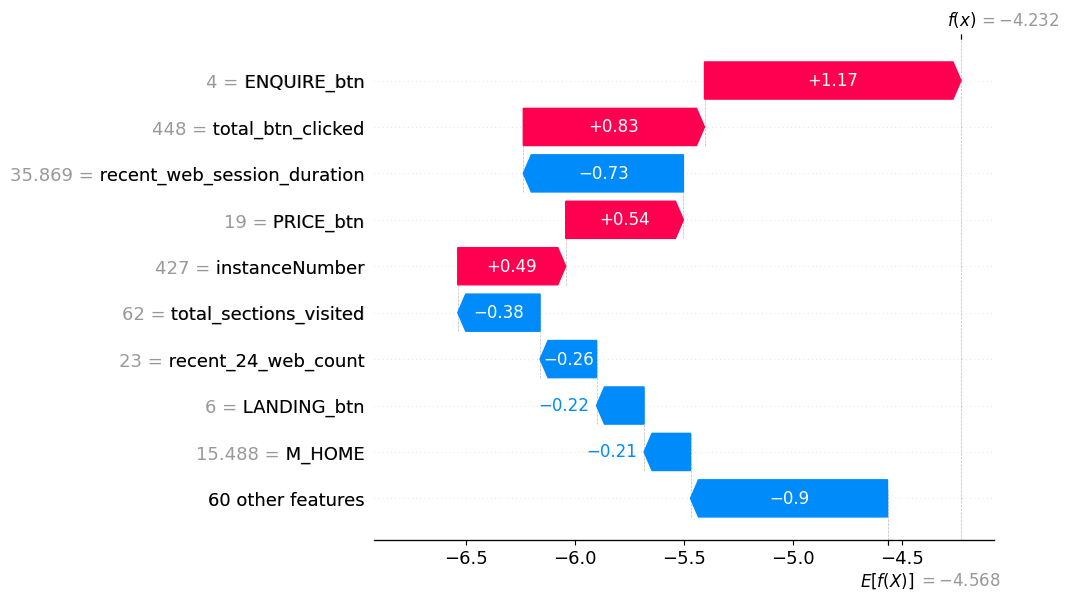

,globalId,_id,start_date_time,createdAt_x,isLead,any_$isLead$_this_week,any_$isLead$_this_week_borne_date,is_lead_created,any_$is_lead_created$_this_week,any_$is_lead_created$_this_week_borne_date,is_old_lead,NoOfVisits,operatingSystem,sourceCampaign,projectId,microMarket,systime_since_first_event_this_week,avg_web_activity_duration,max_web_duration,if_maxweb_in_recent,recent_web_session_duration,time_since_last_web_session,instanceNumber,cummulativeTimeSpent,recent_24,recent_24_cummulativeTimeSpent,recent_48,recent_48_cummulativeTimeSpent,is_loan,loan_entry_count,max_loan_entry_this_week,max_loan_entry_this_visit,map_entry_count,is_map,recent_24_web_count,recent_48_web_count,total_sections_visited,total_pages_visited,OUR_STORY,SPECIFICATIONS,AMENITIES,MEDIA,OUR_PROJECTS,PRICE,LOCATION,PLAN,HOME,PLANS,NEARBY,PARTNER_WITH_US,LANDING,M_OUR_STORY,M_SPECIFICATIONS,M_AMENITIES,M_MEDIA,M_OUR_PROJECTS,M_PRICE,M_LOCATION,M_PLAN,M_HOME,M_PLANS,M_NEARBY,M_PARTNER_WITH_US,M_LANDING,button_counts,URL_HIT_btn,HOME_btn,PLAN_btn,MEDIA_btn,PRICE_btn,AMENITIES_btn,LOCATION_btn,SPECIFICATIONS_btn,LANDING_btn,OUR_PROJECTS_btn,ENQUIRE_btn,EXPLORE_btn,OUR_STORY_btn,QR_btn,BLOGS_btn,PARTNER_WITH_US_btn,EVENTS_btn,POLLS/CCLEX011_btn,"LOCATION#:~:TEXT=BE%20IT%20VIA%20THE%20BALANAGAR,THIS%20SPOT%20ENSURES%20GREAT%20CONNECTIVITY._btn",total_btn_clicked,pred_prob,ground_thruth
2027,8.0,67075fdf0a8a2273ad828150,2024-10-03 05:08:37.479000+00:00,2024-10-10 05:02:23.526000+00:00,False,True,"[2024-10-03 05:32:43.290000+00:00, 2024-10-03 ...",False,True,"[2024-10-03 05:32:43.290000+00:00, 2024-10-03 ...",True,93,Mac,others,65adfbb3f09468f0e32fba49,Gachibowli,10073.76745,283.252232,15610.947,False,35.869,0.0,427,19544.404,"{'HOME$HERO_SECTION': 20.523999999999997, 'HOM...",16333.129,"{'HOME$BROCHURE_SECTION': 97.042, 'HOME$HERO_S...",17474.522,False,0,-1,-1,0,False,23,51,62,11,0.0,50.931,15.409,1696.658,2.465,335.84,1.596,521.666,1169.55,0,0,0.0,138.904,0.0,0.0,0.0,4.338,0.0,0.0,0.0,0.0,15.488,0,0,0.0,0,"{'URL_HIT': 93, 'HOME': 63, 'PLAN': 212, 'MEDI...",93,63,212,46,19,1,1,3,6,0,4,0,0,0,0,0,0,0,0,448,0.014564,False


In [ ]:
import shap

# Select a specific data point (e.g., first instance in X_test)
instance_idx = 0  # Change this index as needed
explainer = shap.Explainer(model1)
shap_values_instance = explainer(X_valid.iloc[[instance_idx]])

# Visualize as a waterfall plot
shap.plots.waterfall(shap_values_instance[0])
valid_mapping.iloc[[instance_idx]]

# Hyperparameter Tuning

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import ParameterGrid

# Define parameter grid 4*3*3*3*3*3
param_grid = {
    'max_depth': [10, 20, 30, 50],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Track best model and its metrics
best_model = None
best_recall = 0
best_params = None

# Iterate through parameter combinations
for params in ParameterGrid(param_grid):
    model = xgb.XGBClassifier(
        **params,
        eval_metric='logloss',
        tree_method='hist',
        enable_categorical=True,
        device='cuda'
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    recall = recall_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)

    print(f"Parameters: {params}")
    print(f"Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}\n")

    if recall > best_recall:
        best_recall = recall
        best_model = model
        best_params = params

print("Best Parameters:", best_params)
print("Best Recall on X_valid:", best_recall)

Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Recall: 0.1433 | Precision: 0.8828 | Accuracy: 0.9844

Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Recall: 0.1472 | Precision: 0.8856 | Accuracy: 0.9845

Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Recall: 0.1421 | Precision: 0.8822 | Accuracy: 0.9844

Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
Recall: 0.3779 | Precision: 0.7990 | Accuracy: 0.9872

Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Recall: 0.3836 | Precision: 0.7967 | Accuracy: 0.9873

Parameters: {'colsample_b

In [ ]:
colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 50, min_child_weight= 10, n_estimators= 300, subsample= 1.0
